# Collocation tool

The collocation tool visualise for each year in the dataset the number of times technology and emotion keywords appears together within a window of 10 words. 

## Import the relevant libraries

In [10]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
tqdm.pandas()

# Get data from the csv file

In [11]:
input_dir = Path.cwd() / '../data/csv_files' # input directory
df = pd.read_csv(input_dir /'text_data.csv', sep='|')

## Remove stopwords

In [12]:
# get stop words list
input_dir = Path.cwd() / '../data/stopwords' # input directory
with open(input_dir  / 'fr_stopwords.txt', 'r', encoding='utf-8-sig') as f:
    stopwords =  f.read()

stopword_list = stopwords.split('\n')

def remove_stopwords(text_string, stopword_list):
    
    tokens = text_string.split(' ')

    wo_stopword = [i for i in tokens if i not in stopword_list]
    
    return ' '.join(wo_stopword)


df['clean_text_wo_stopwords'] = df['clean_text'].progress_apply(lambda x : remove_stopwords(x, stopword_list))

  0%|          | 0/90 [00:00<?, ?it/s]

In [13]:
from collections import defaultdict, Counter

# text input
clean_text_groupby_year = df.groupby(by='year').agg({'clean_text_wo_stopwords': 'sum'}).reset_index()


# Read keyword lists
input_dir = Path.cwd() / '../data/key_word_lists'
with open(input_dir / 'technology_list.txt', 'r', encoding='utf-8-sig') as f:
    keywords1 = f.read().split()

with open(input_dir / 'emotion_list.txt', 'r', encoding='utf-8-sig') as f:
    keywords2 = f.read().split()


# Define the 'windows size'
# Define the function to process each row
def process_text(text_string):
    tokens = text_string.split()
    window_size = 10
    collocates_dict = defaultdict(Counter)
    
    for i, word in enumerate(tokens):
        if word in keywords1:
            start = max(0, i - window_size)
            end = min(len(tokens), i + window_size + 1)
            context = tokens[start:i] + tokens[i+1:end]
            filtered_context = [w for w in context if w in keywords2]
            collocates_dict[word].update(filtered_context)
    
    results = []
    for term, collocates in collocates_dict.items():
        for collocate, count in collocates.items():
            results.append({'Term': term, 'Collocate': collocate, 'Count': count})

    return results

# Apply the function to each row and store the results in a new column
clean_text_groupby_year['collocates'] = clean_text_groupby_year['clean_text_wo_stopwords'].apply(process_text)

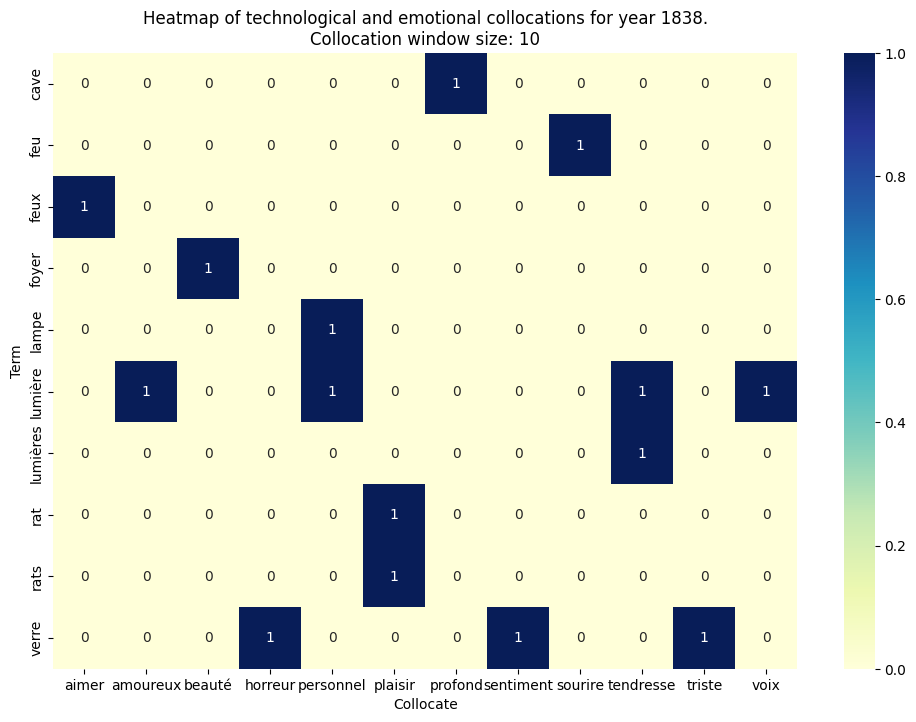

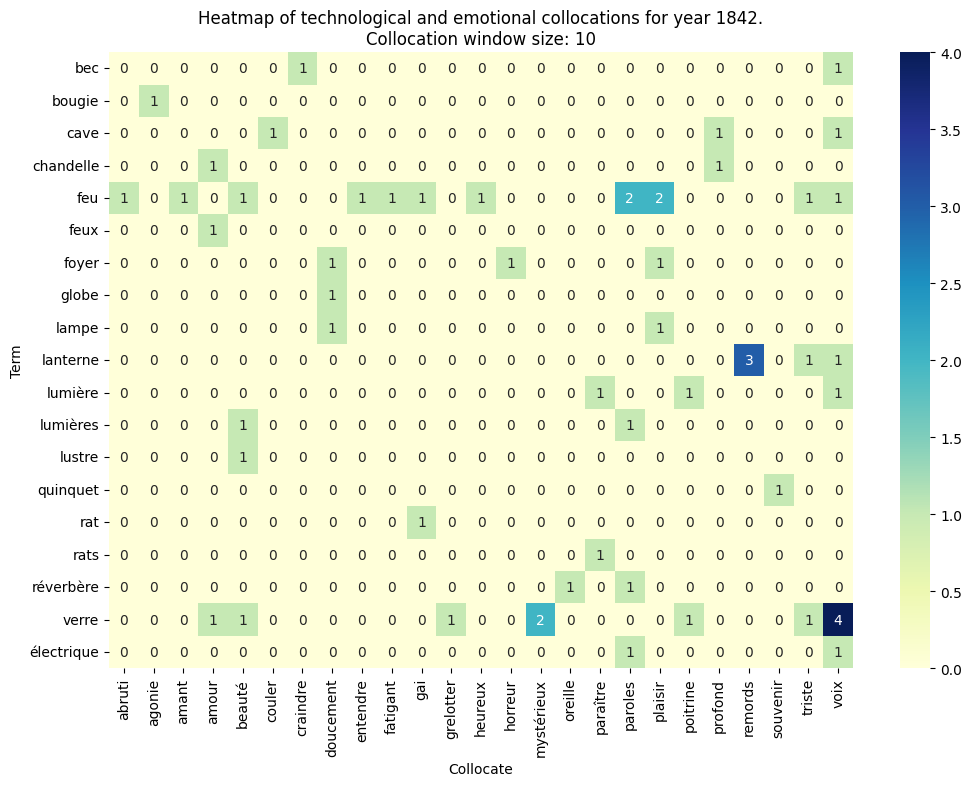

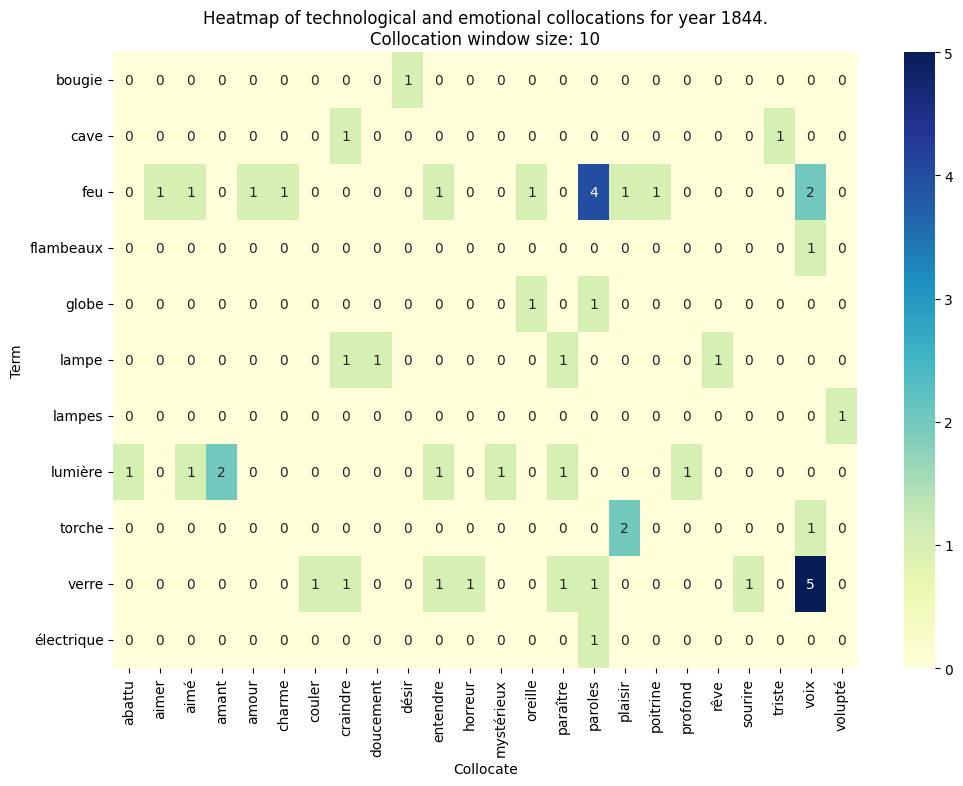

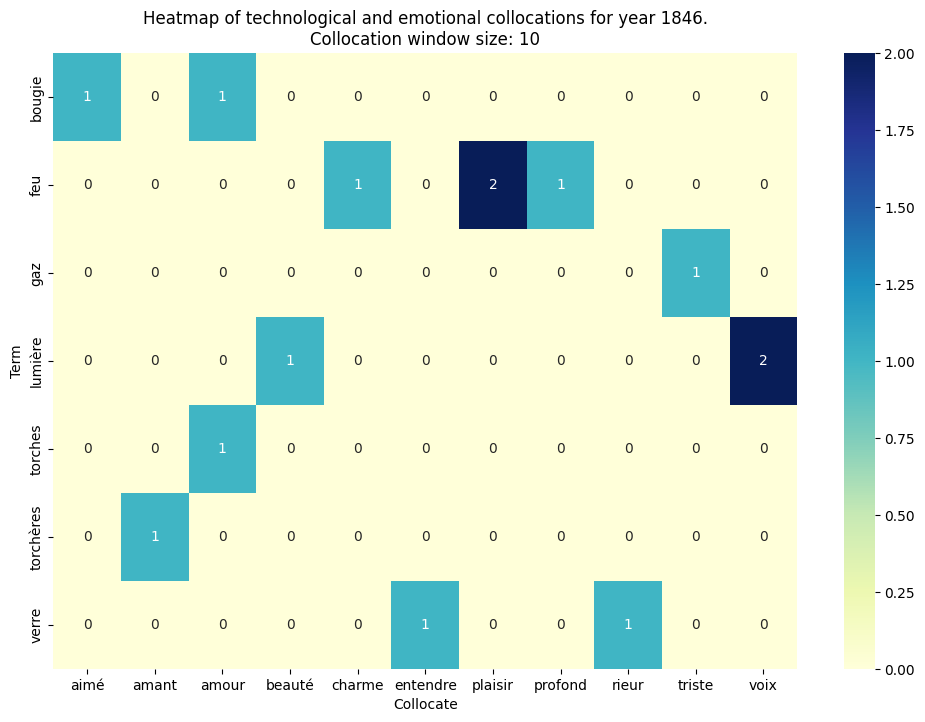

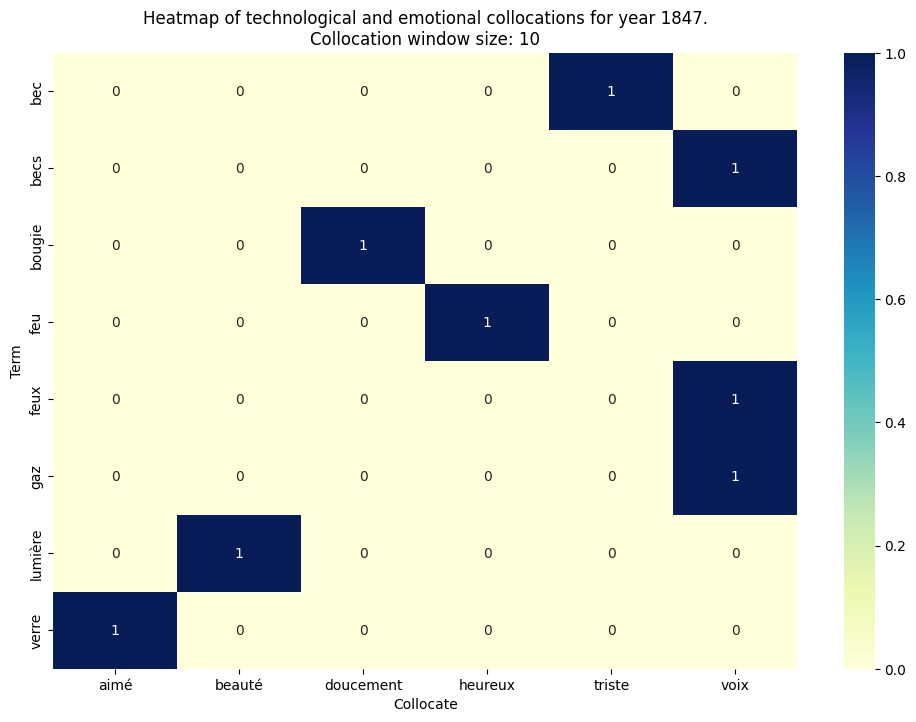

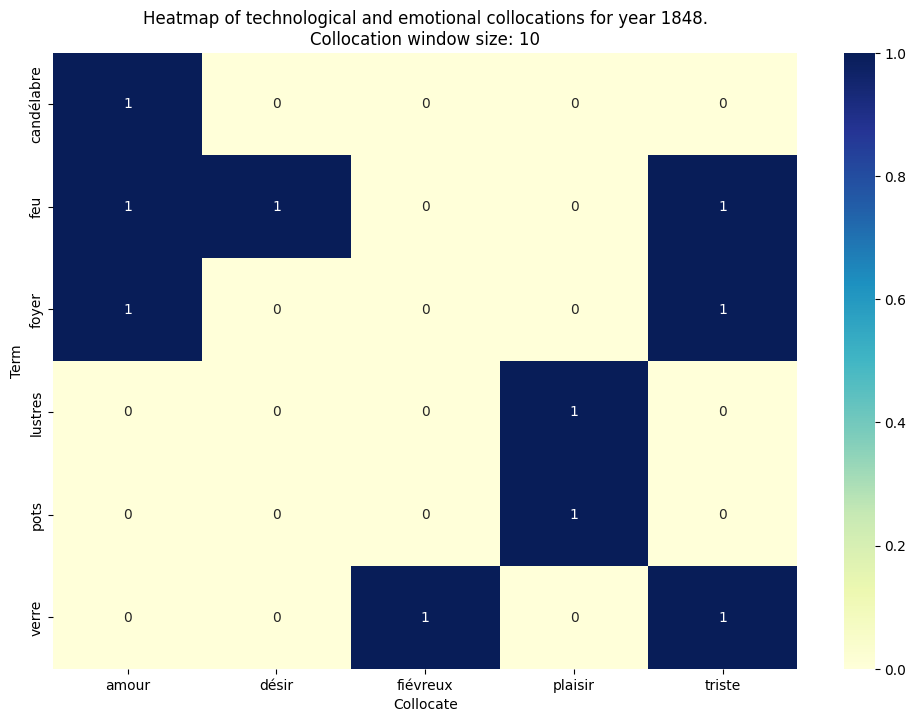

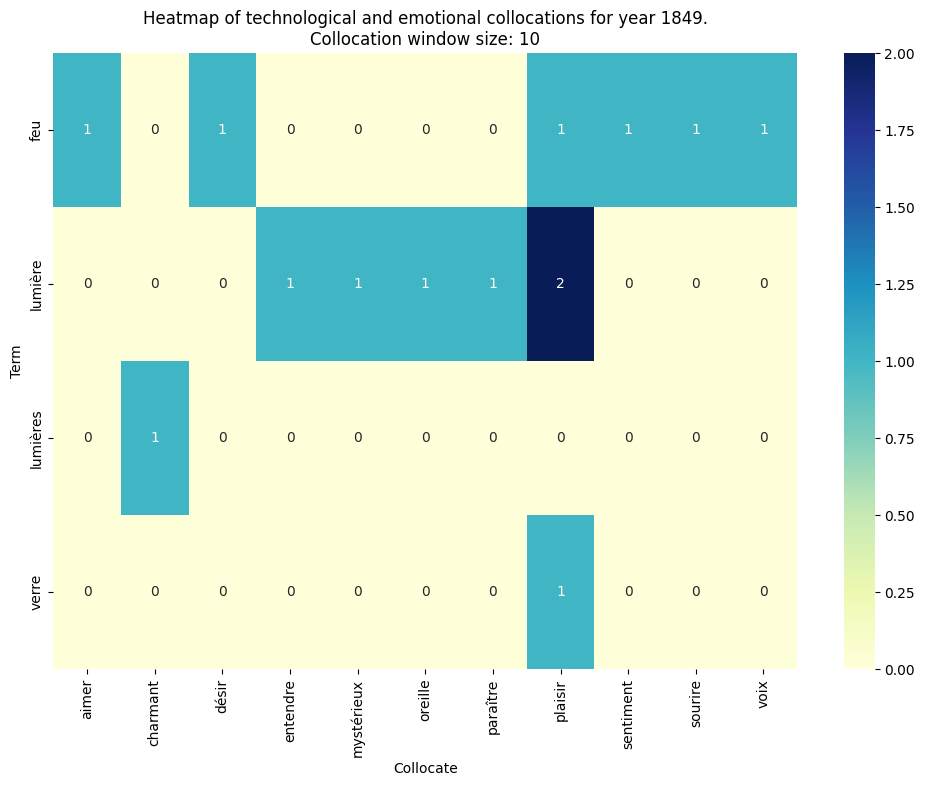

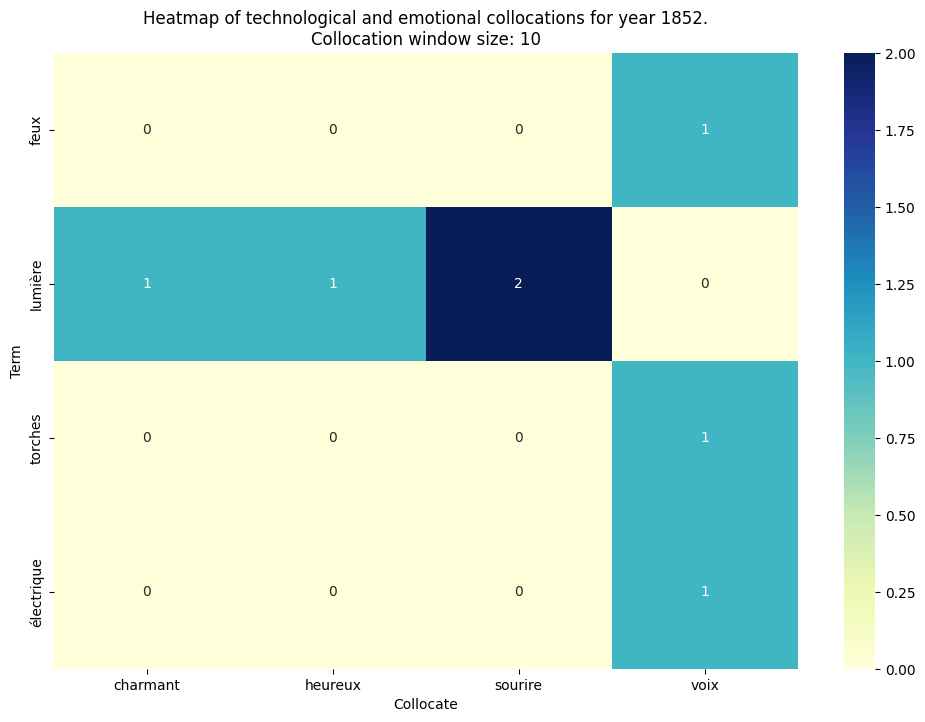

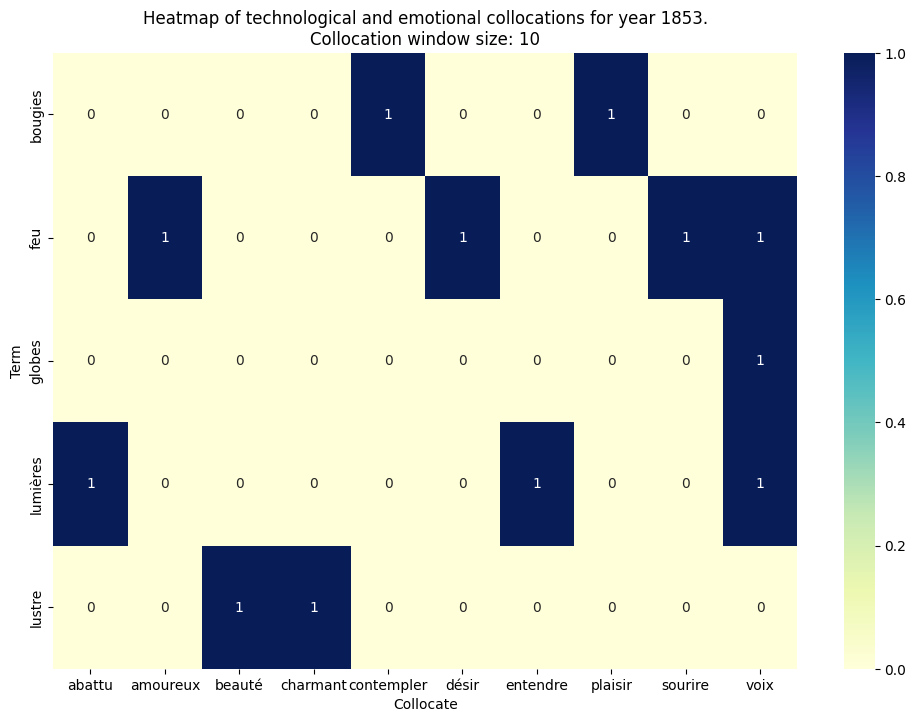

Skipping year 1856 due to missing 'Count' column.


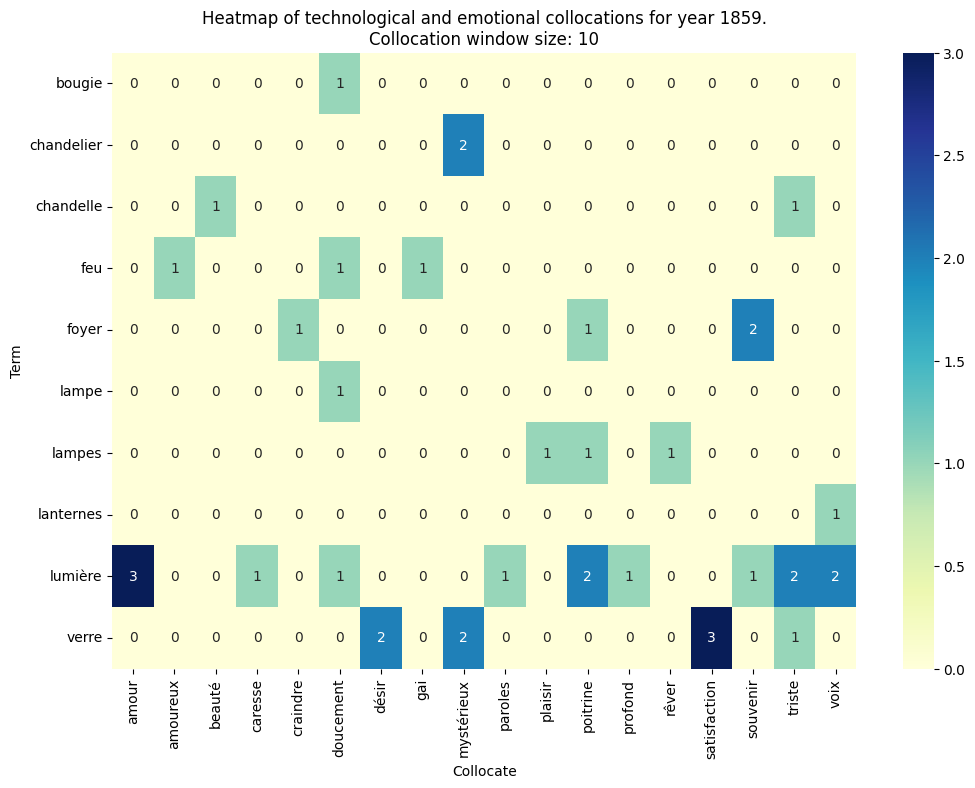

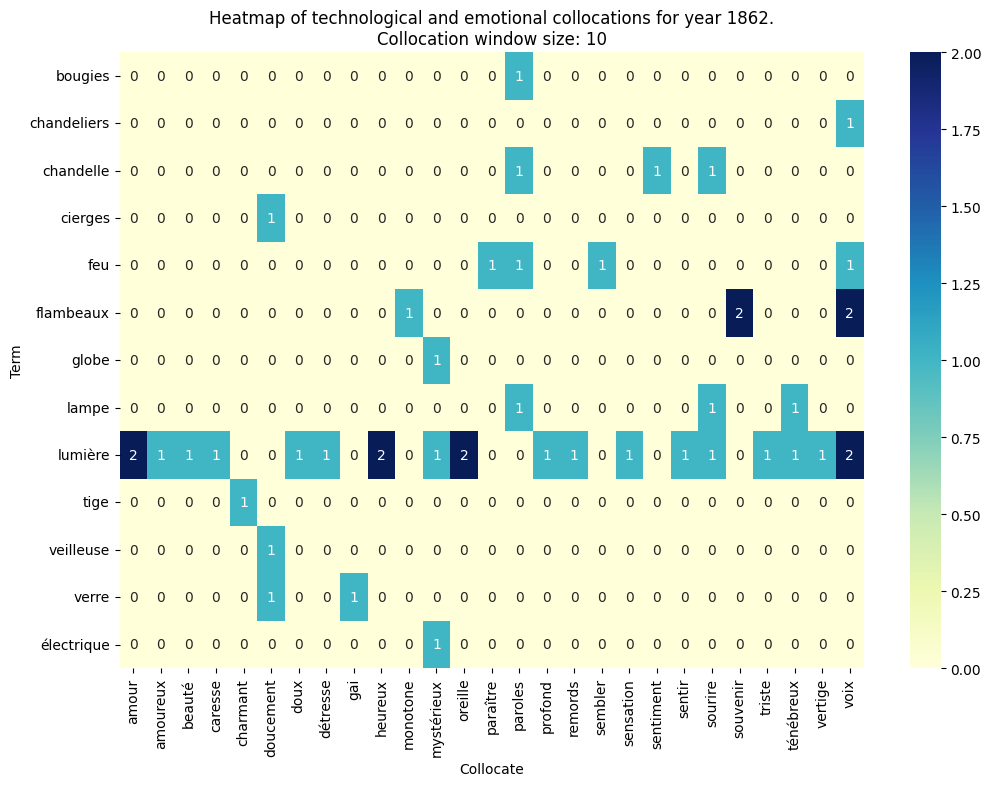

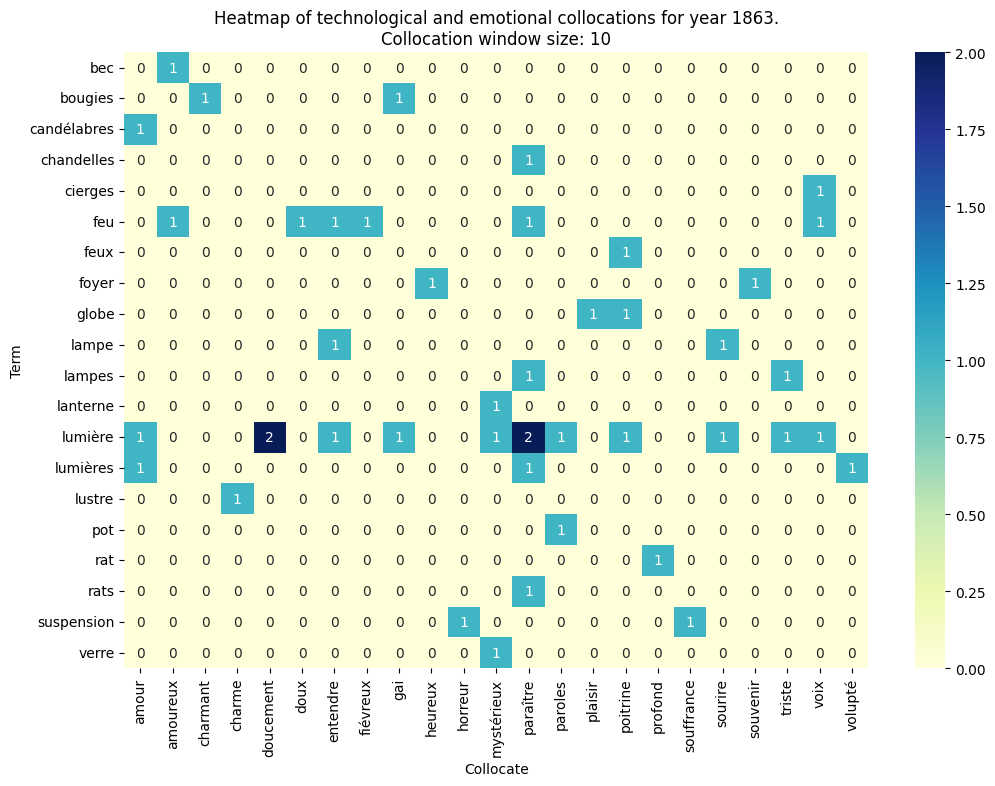

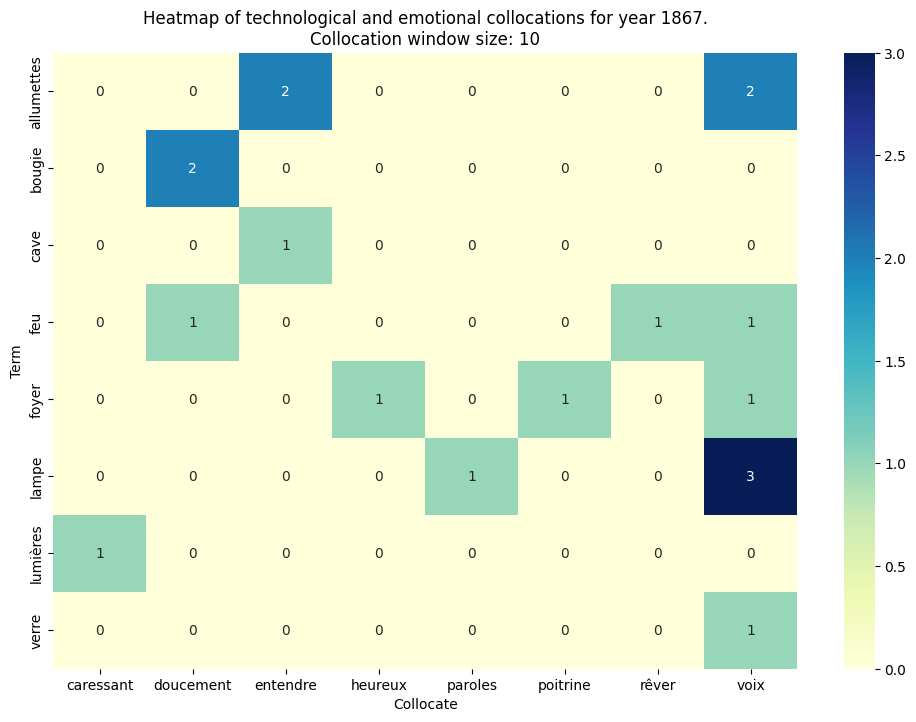

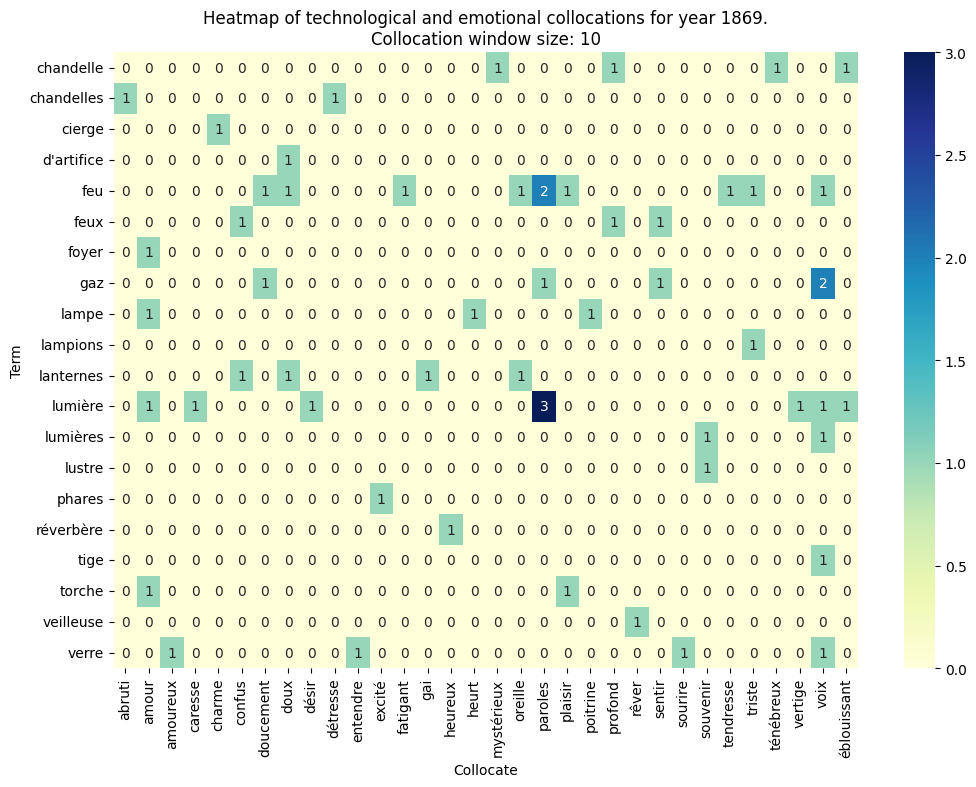

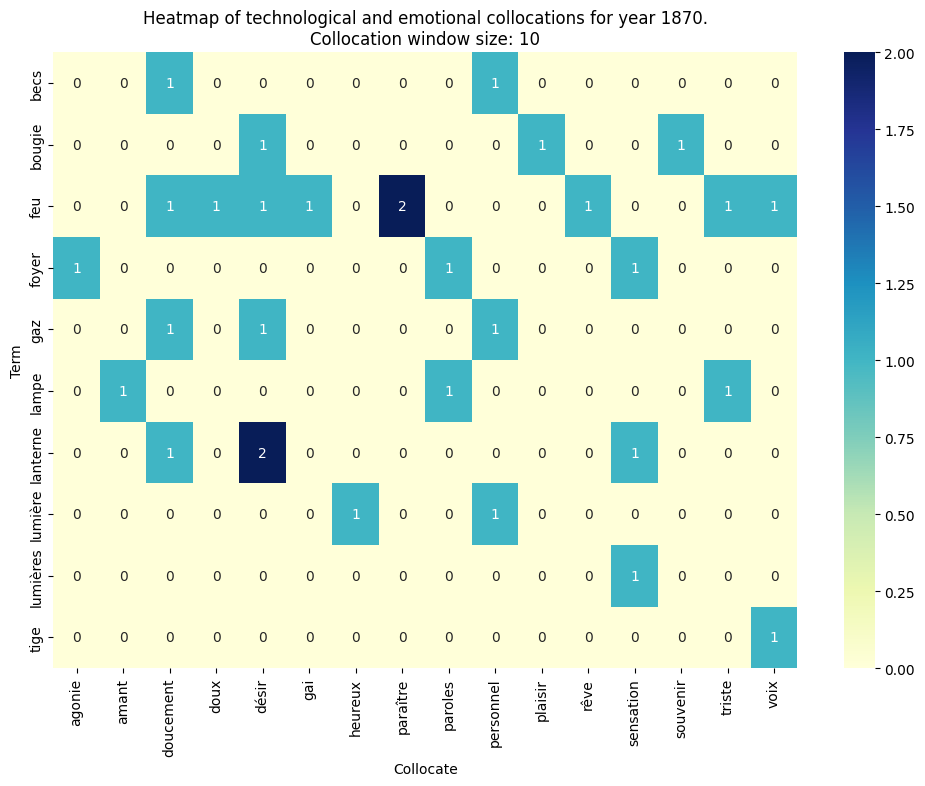

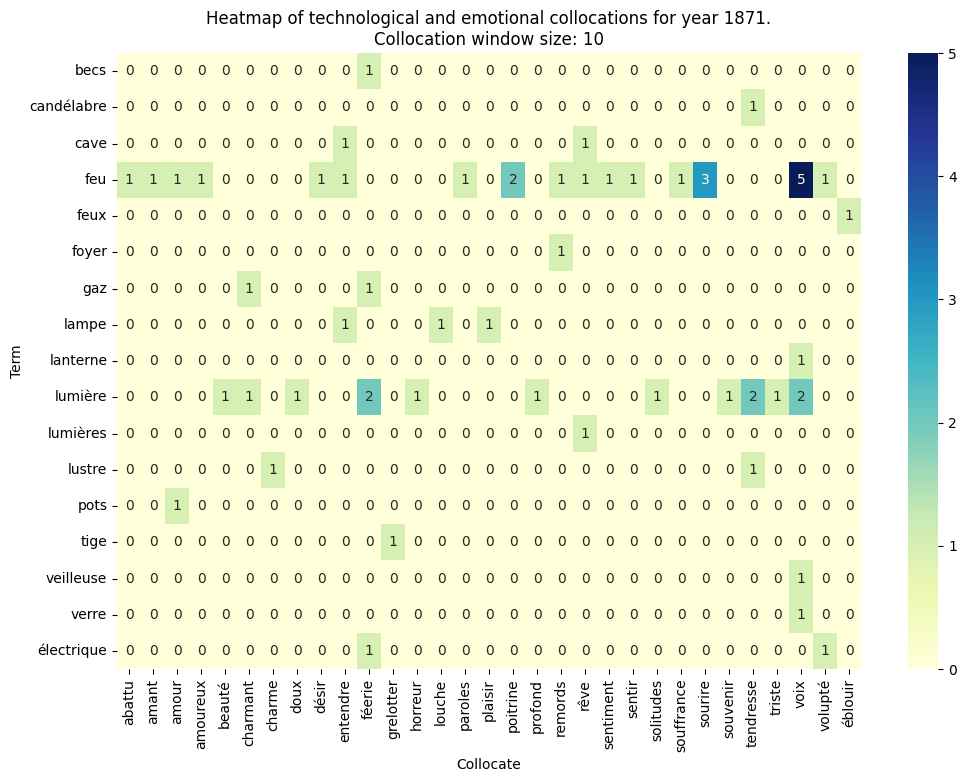

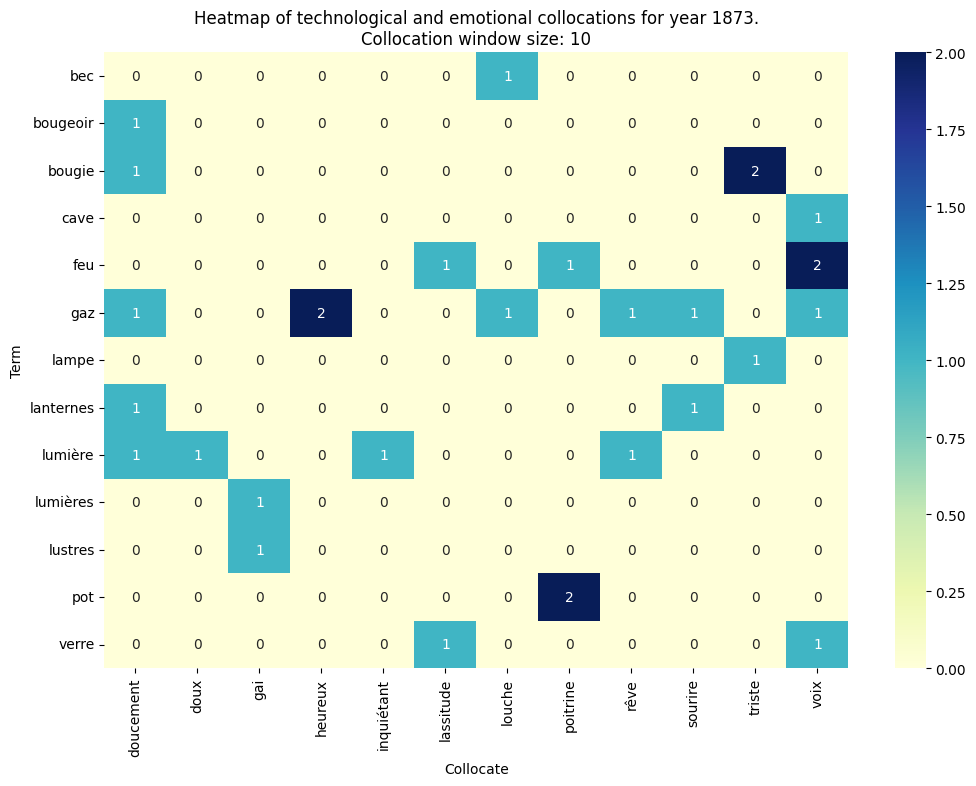

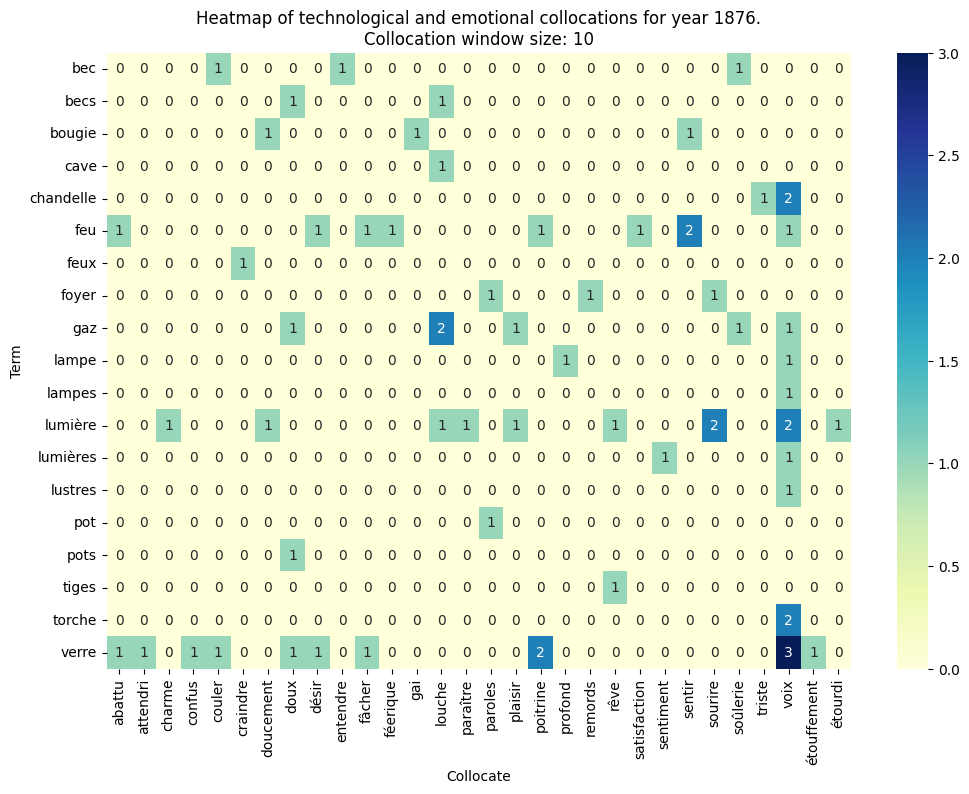

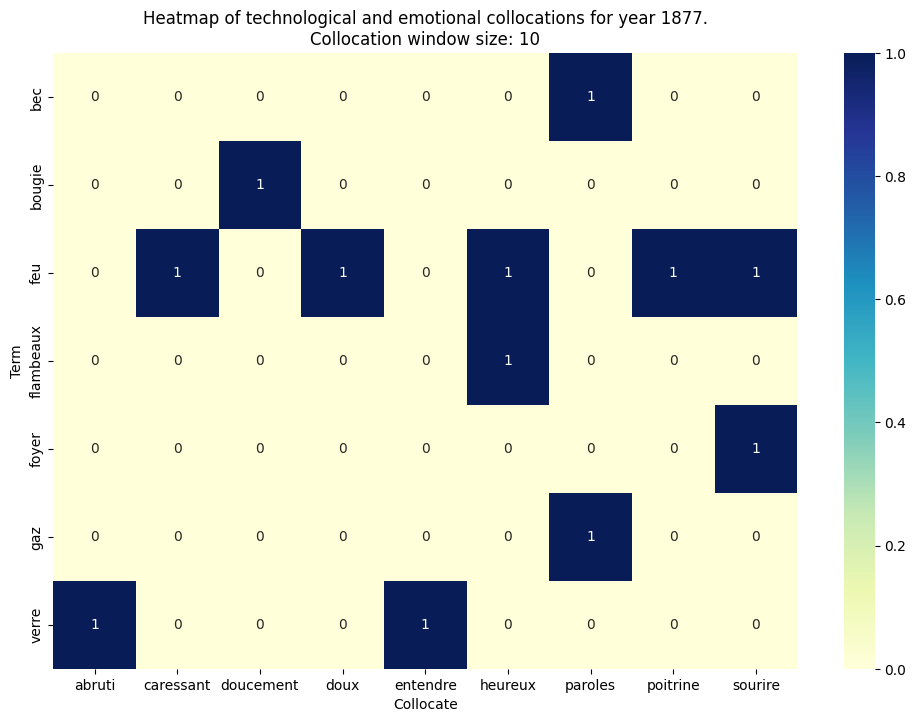

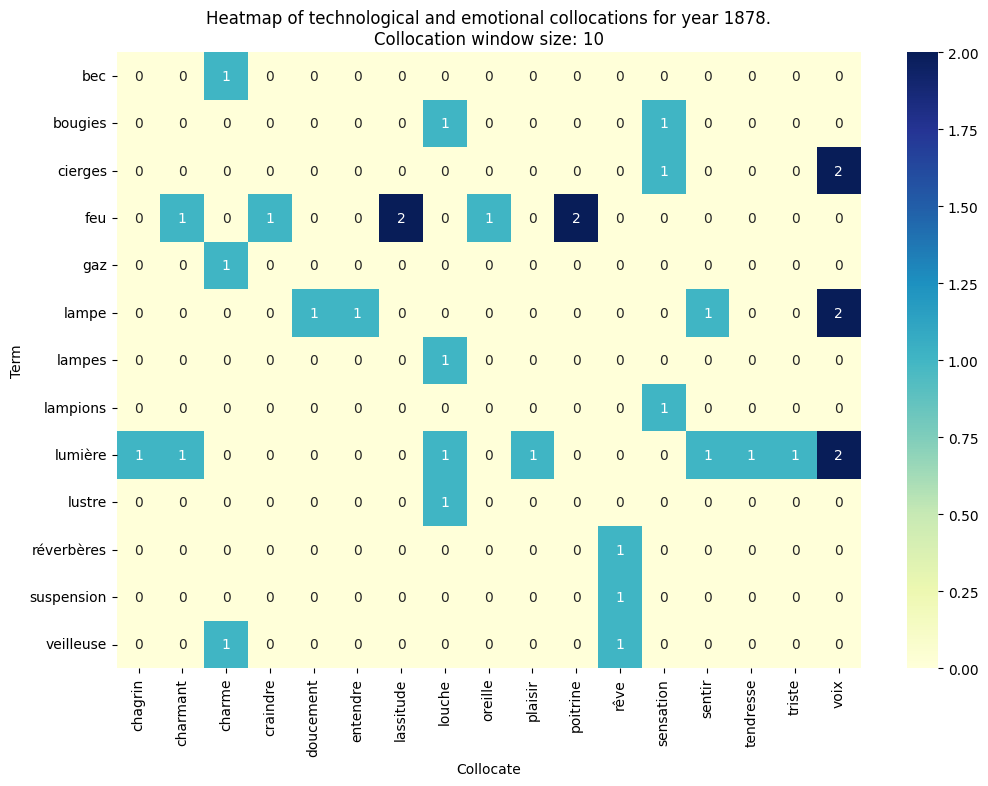

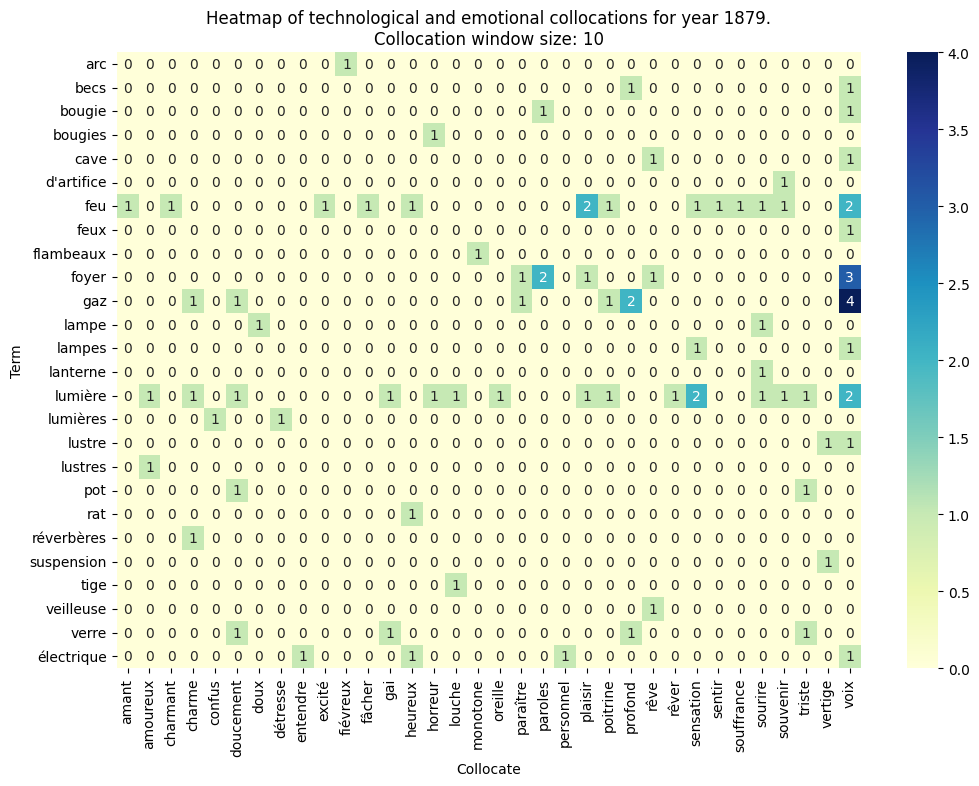

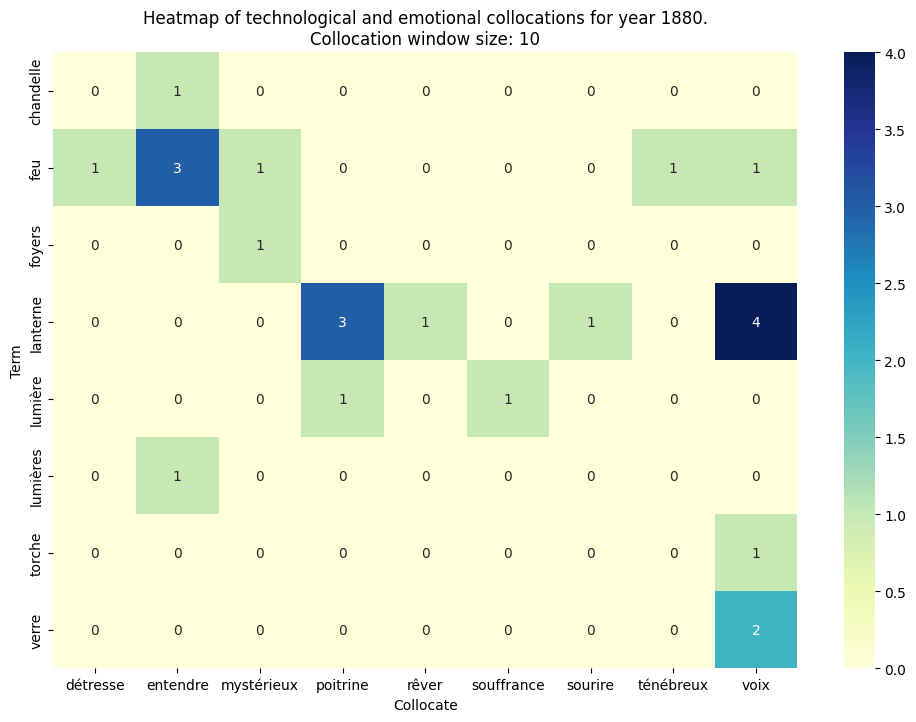

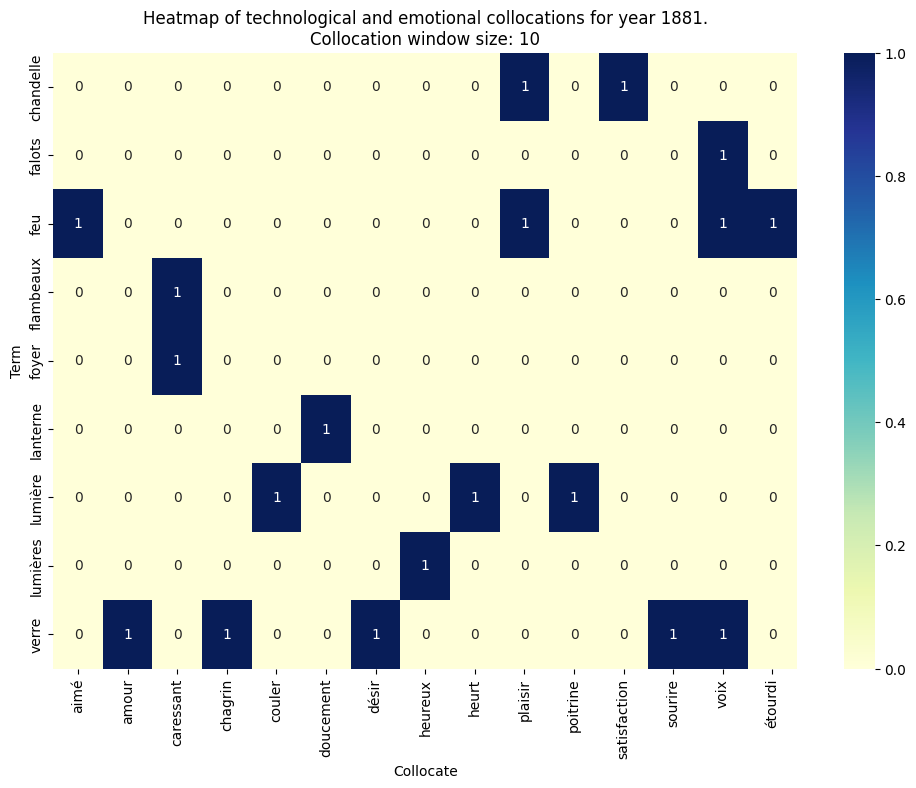

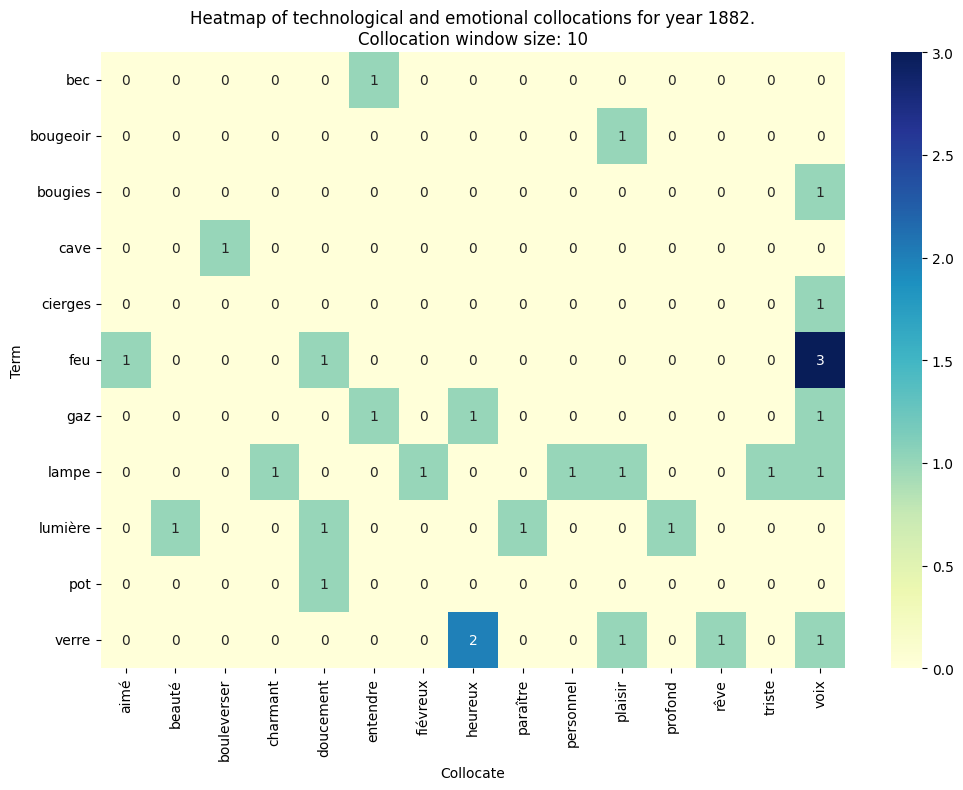

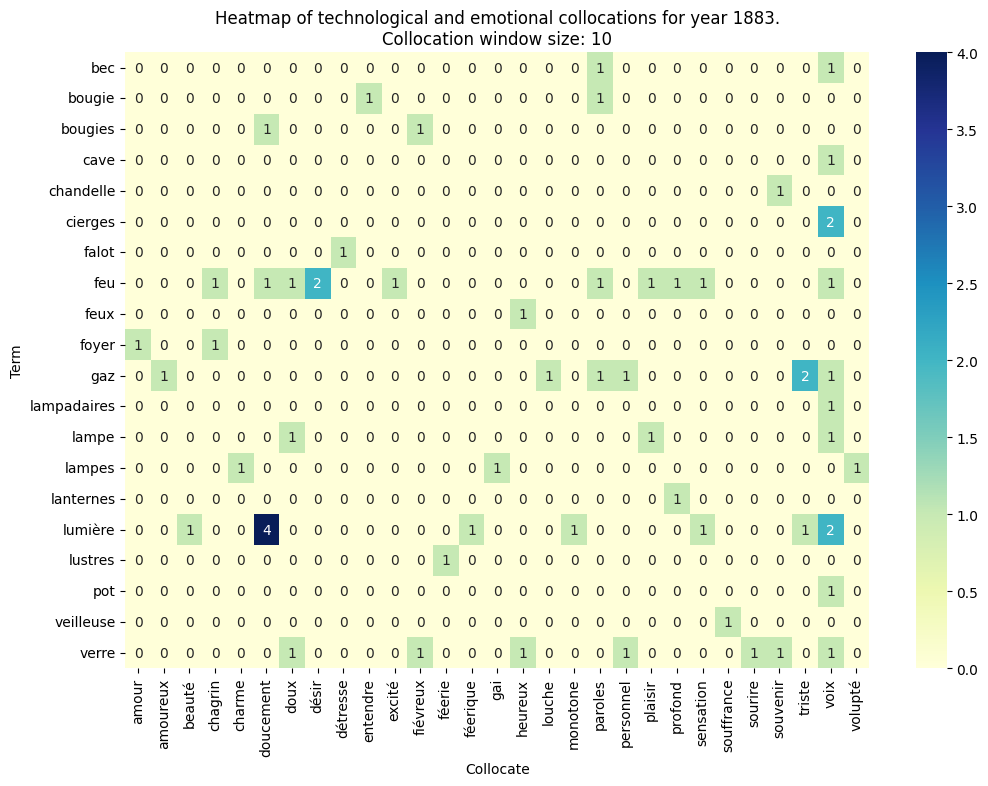

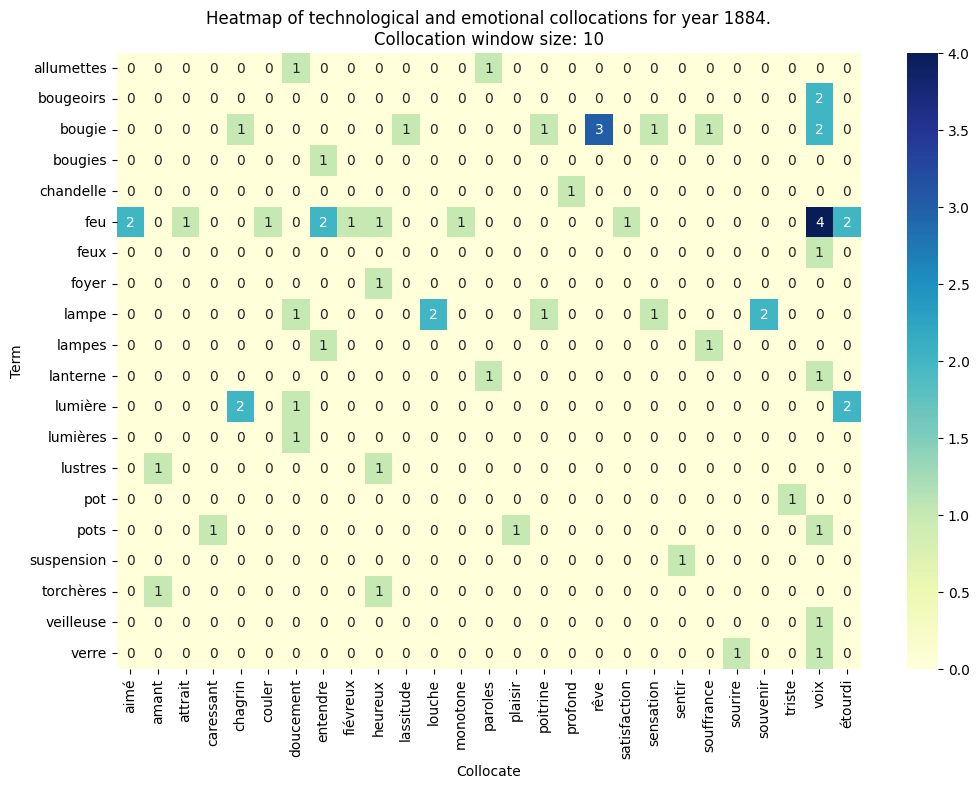

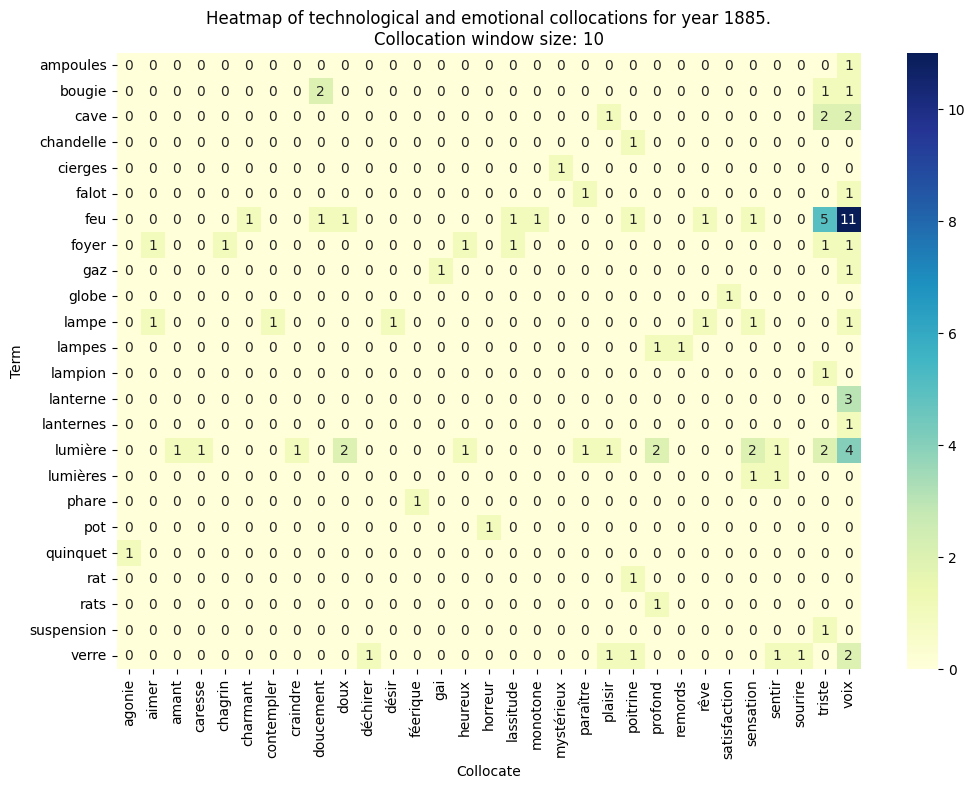

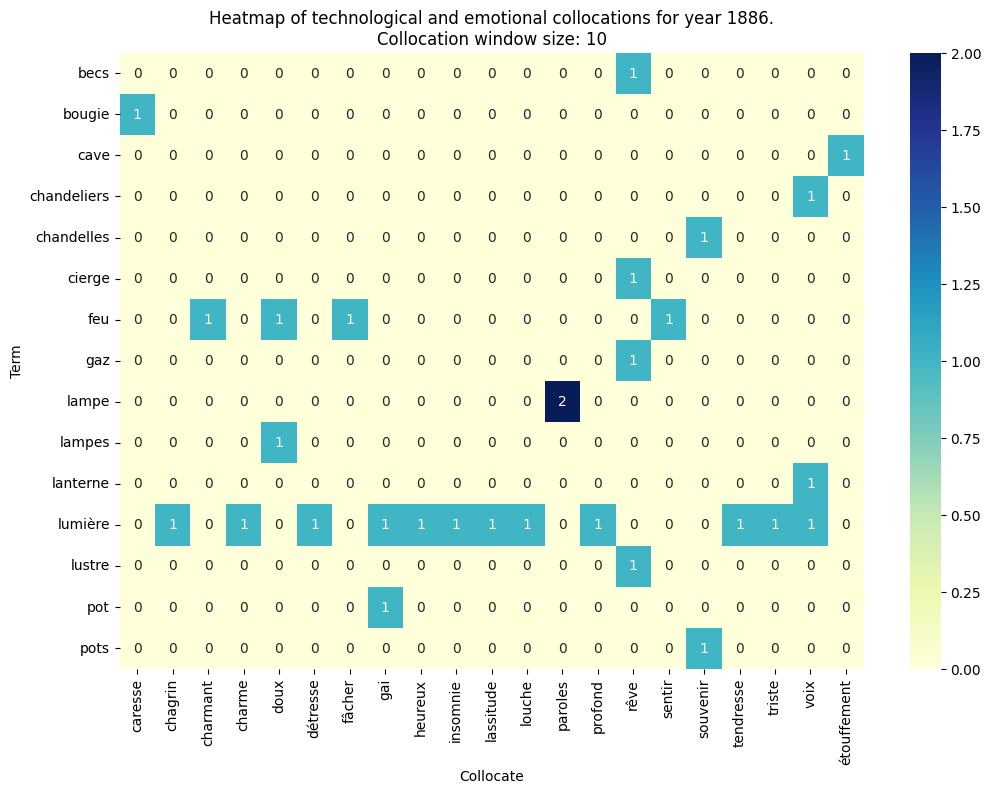

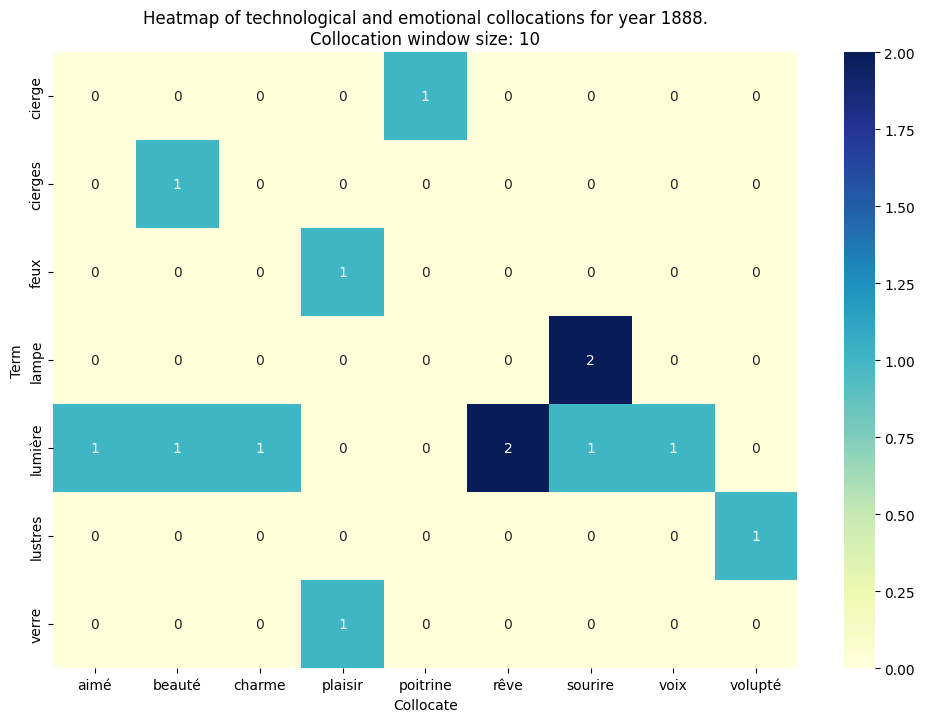

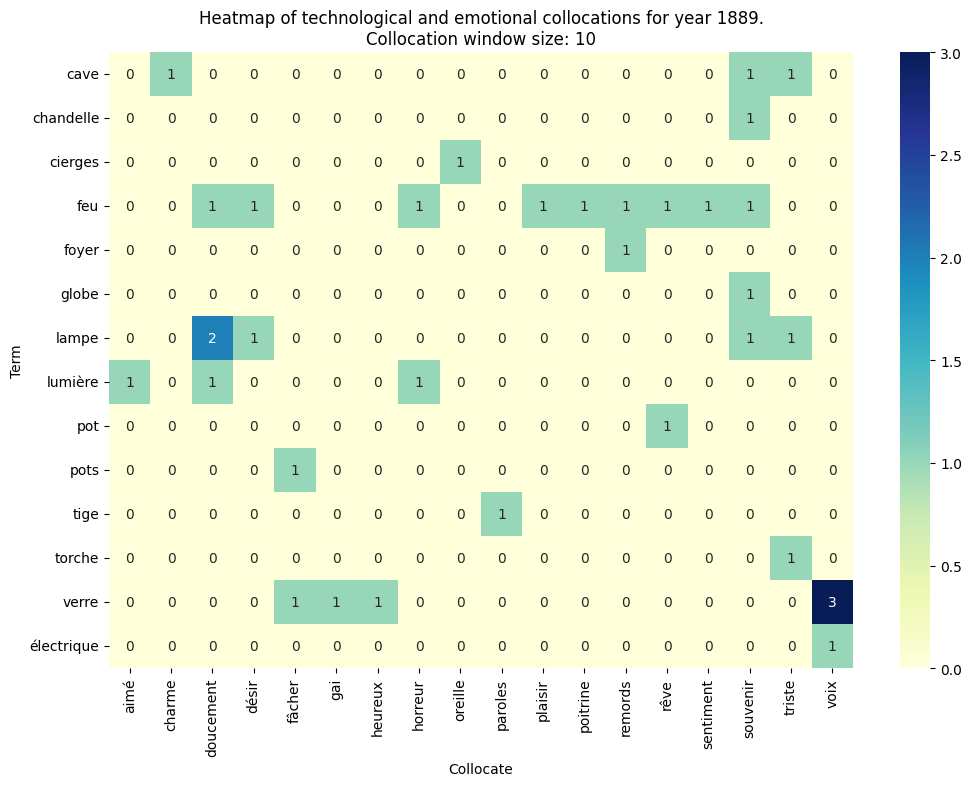

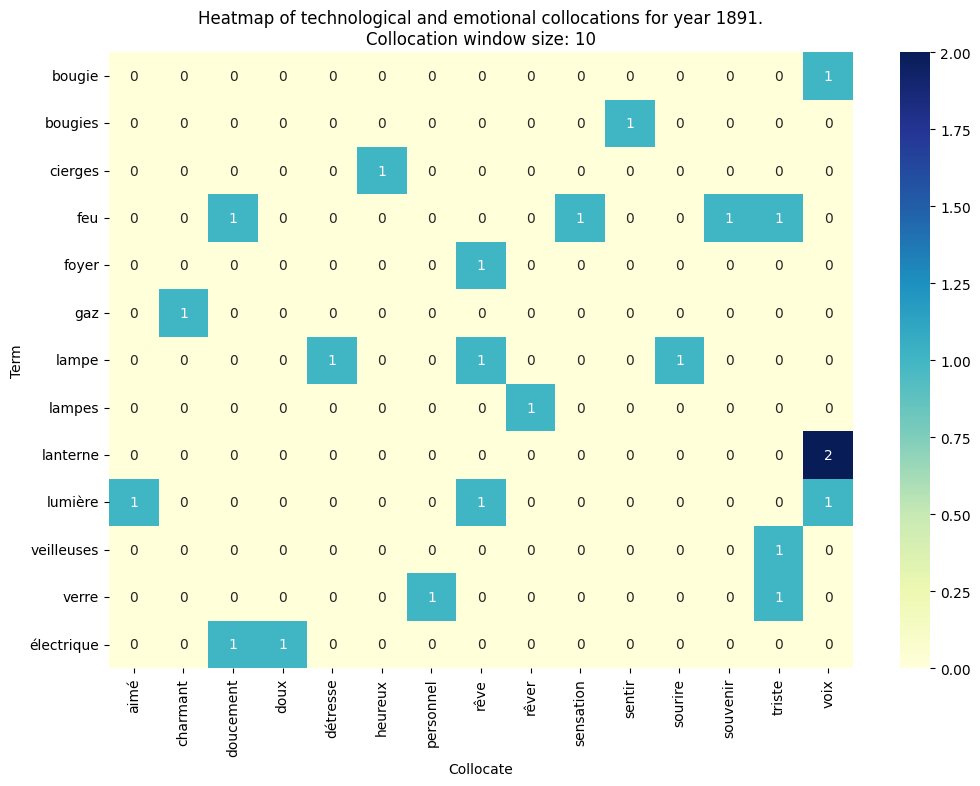

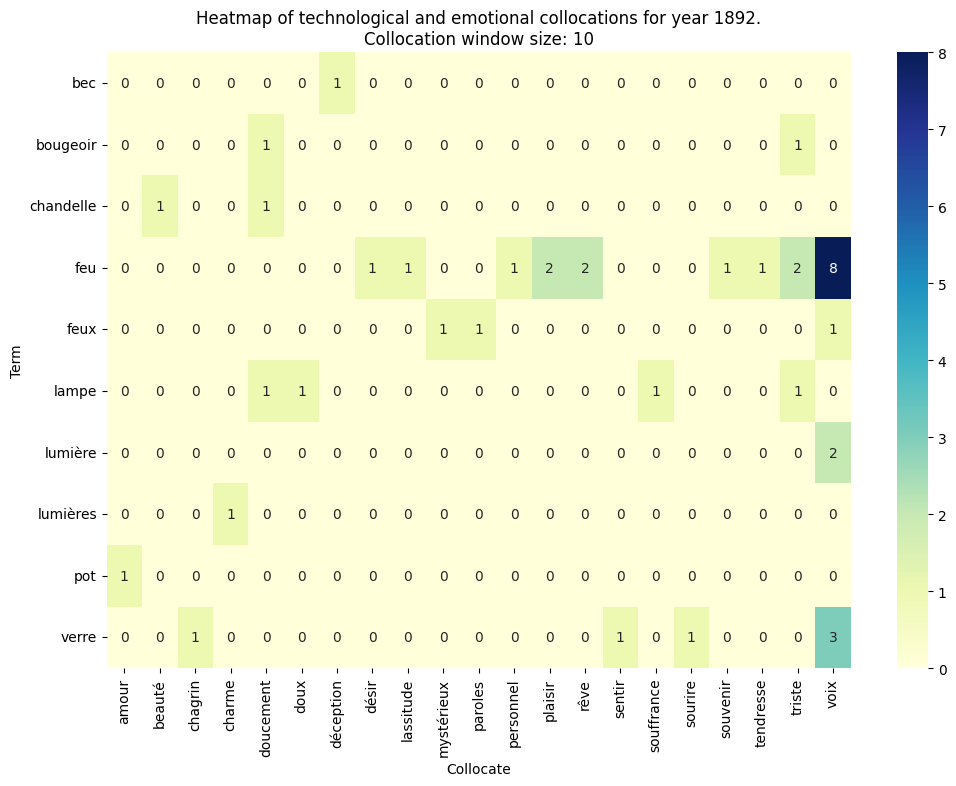

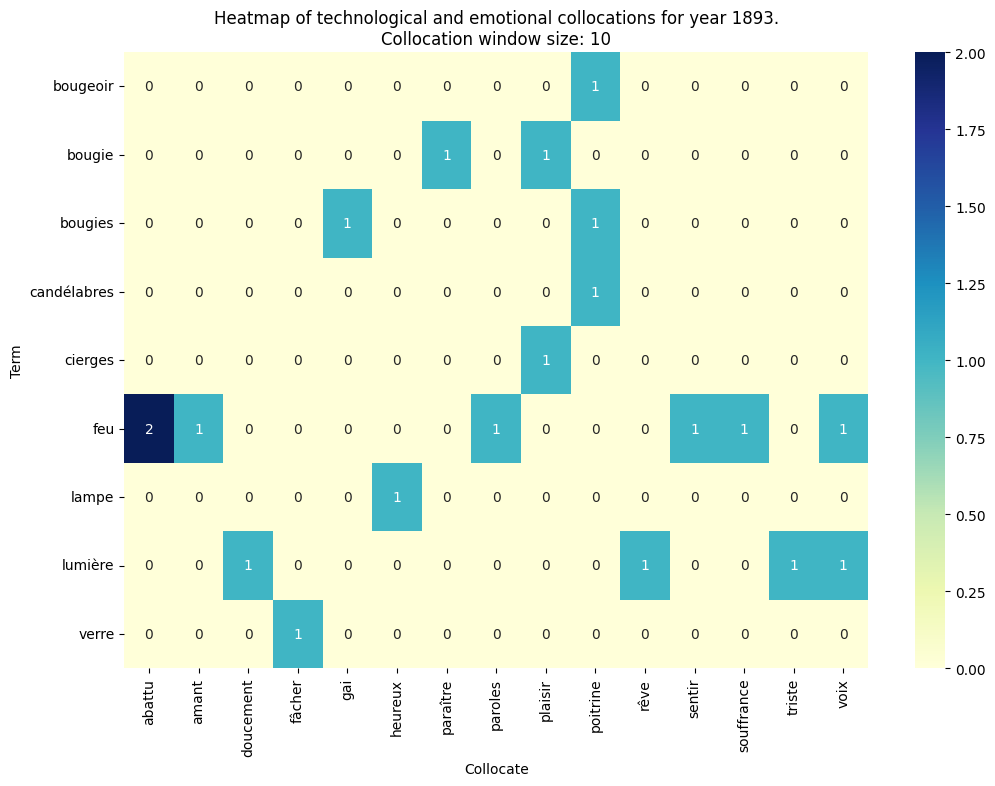

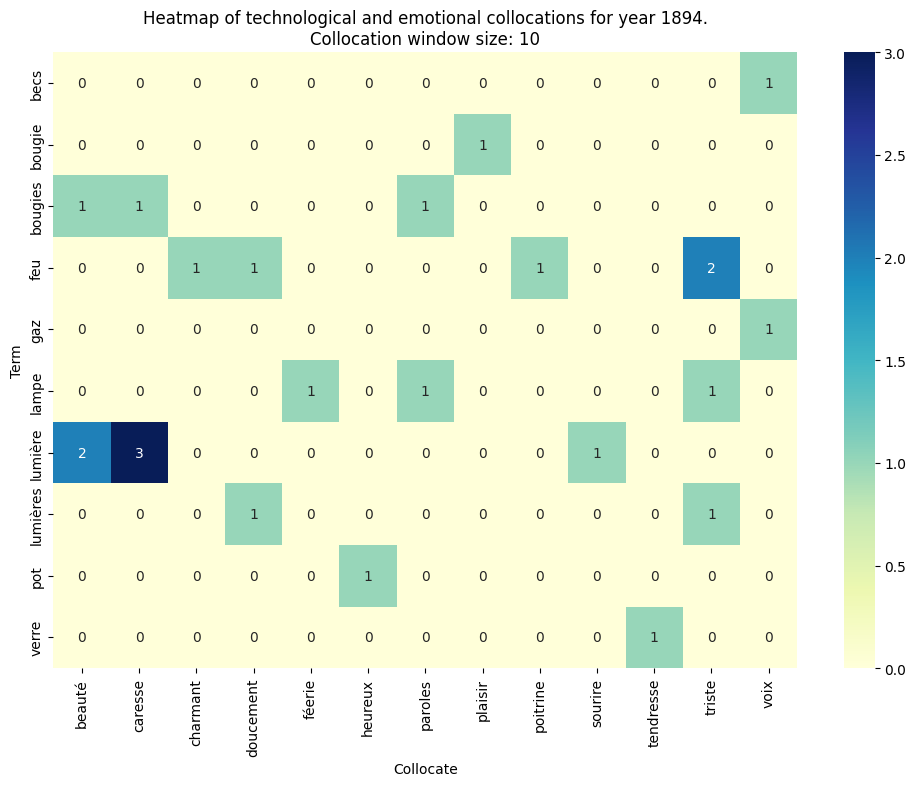

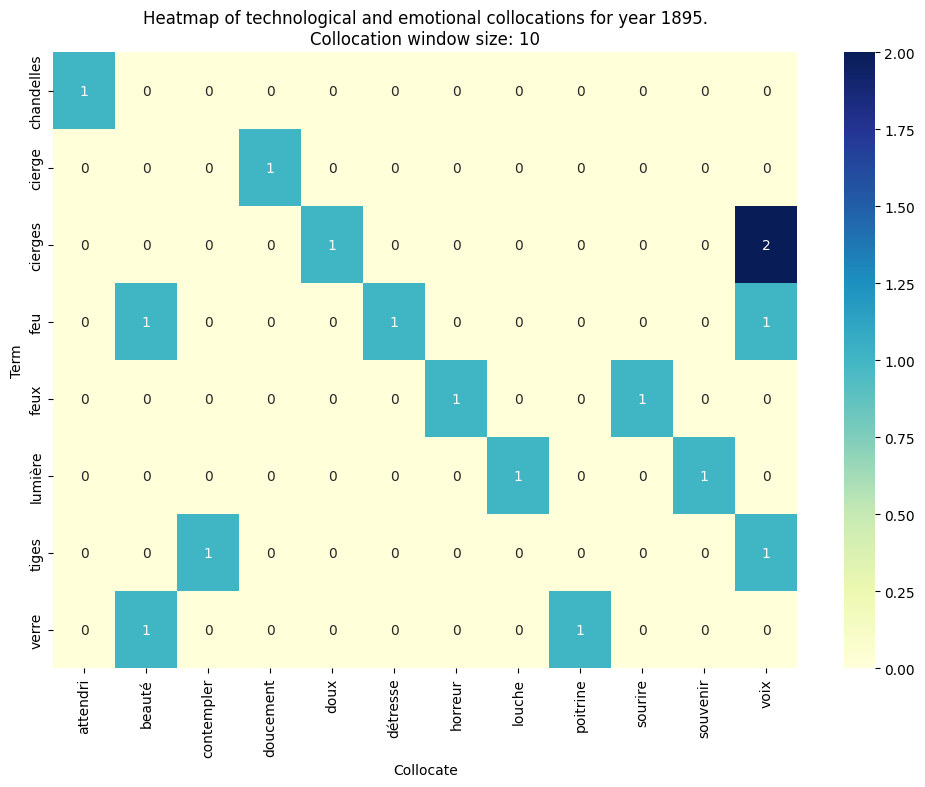

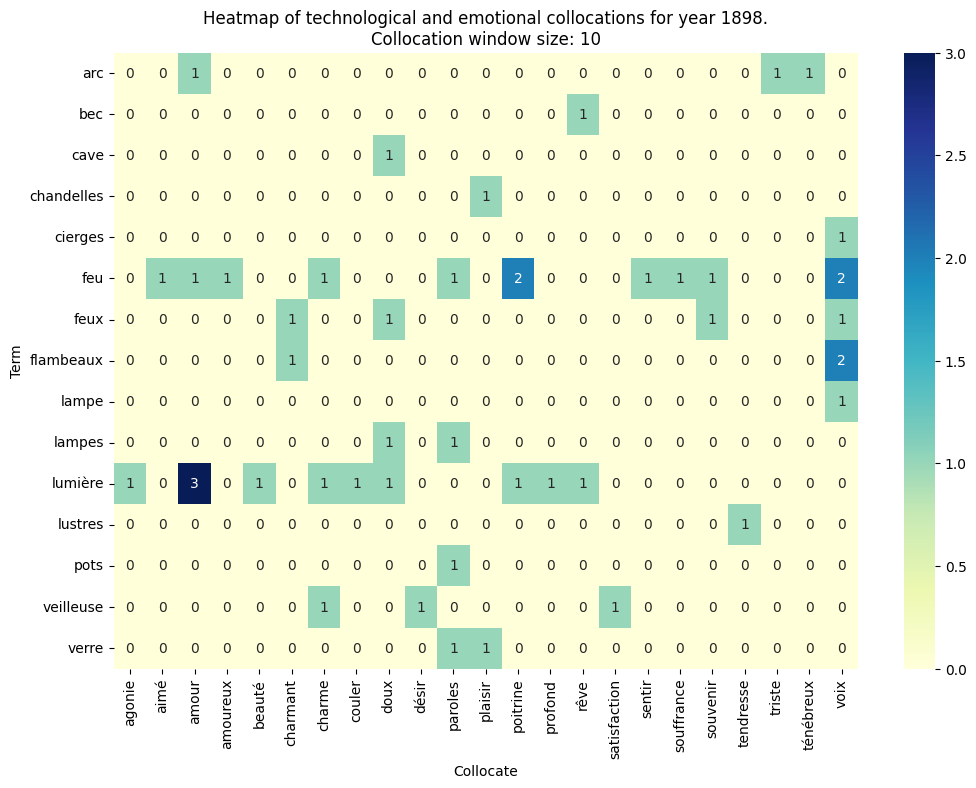

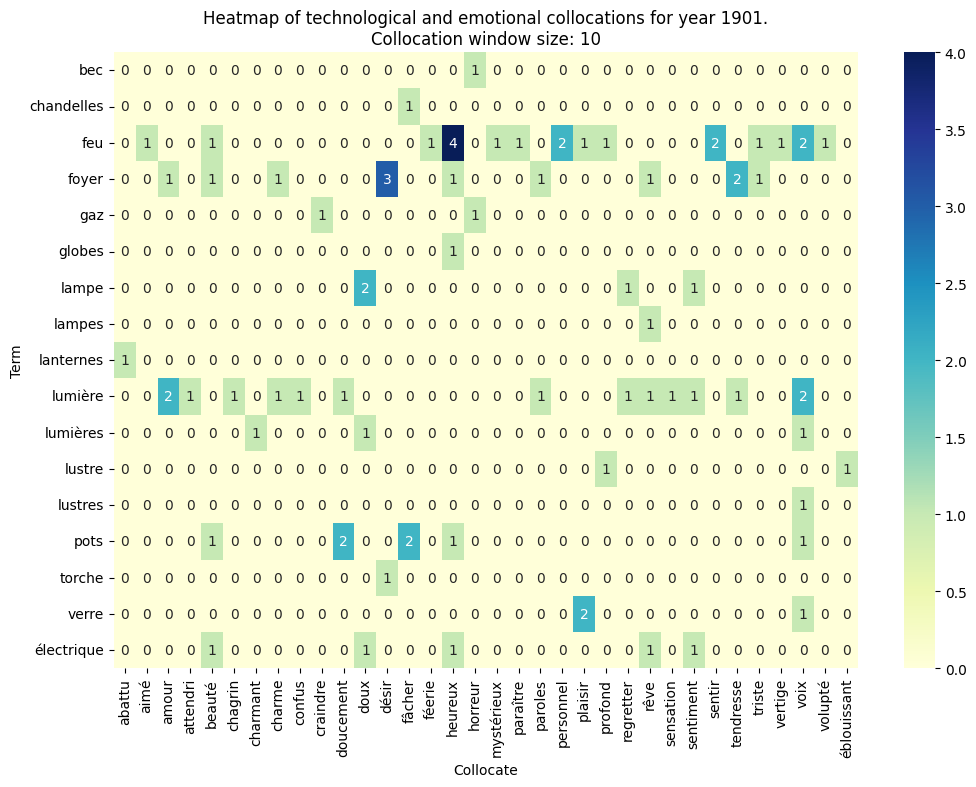

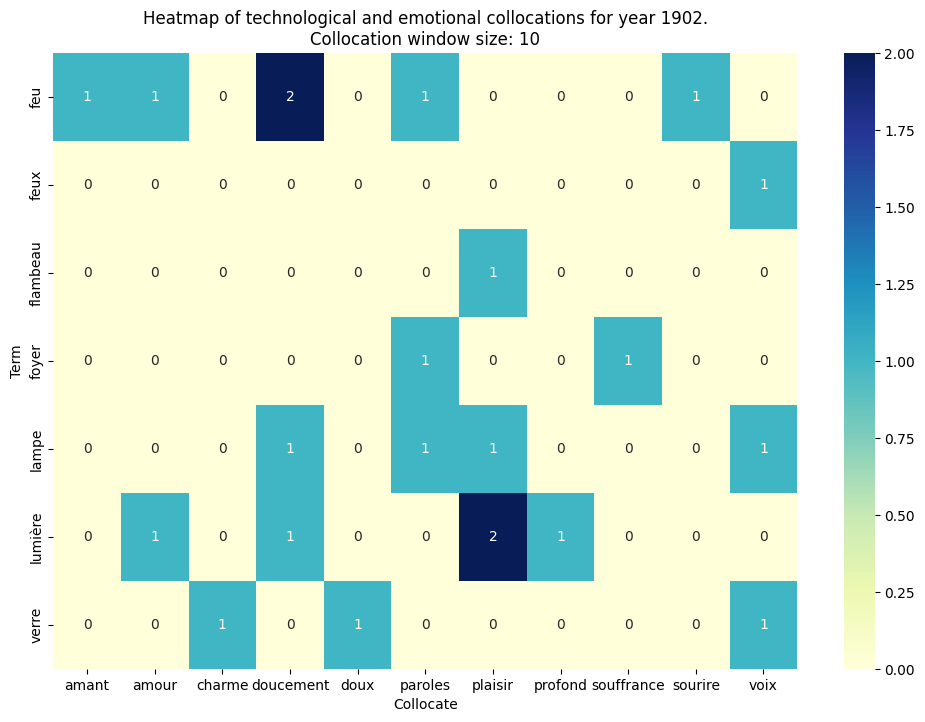

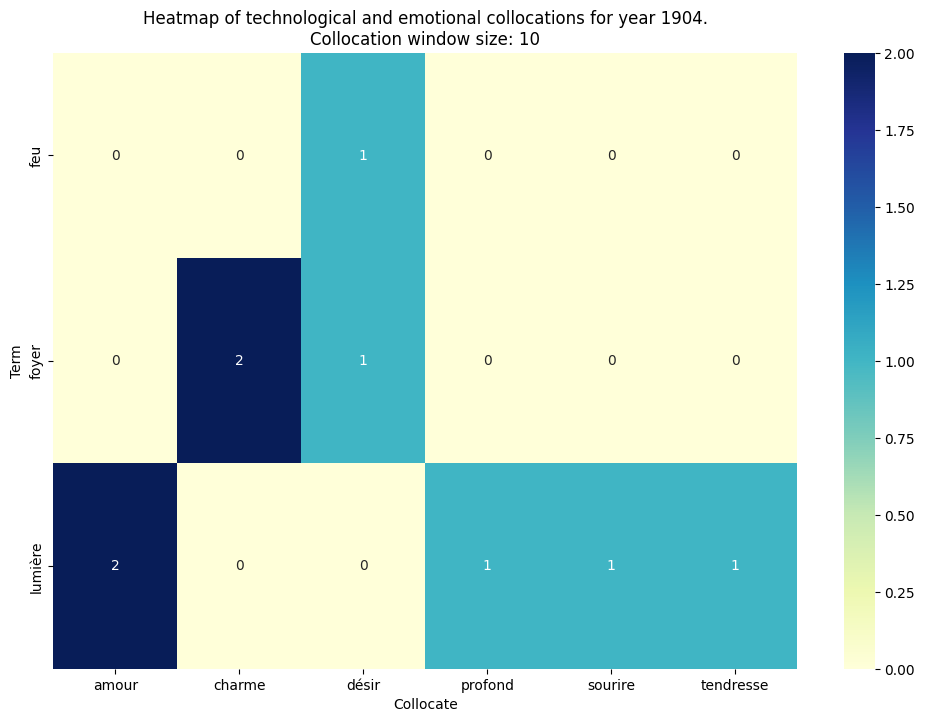

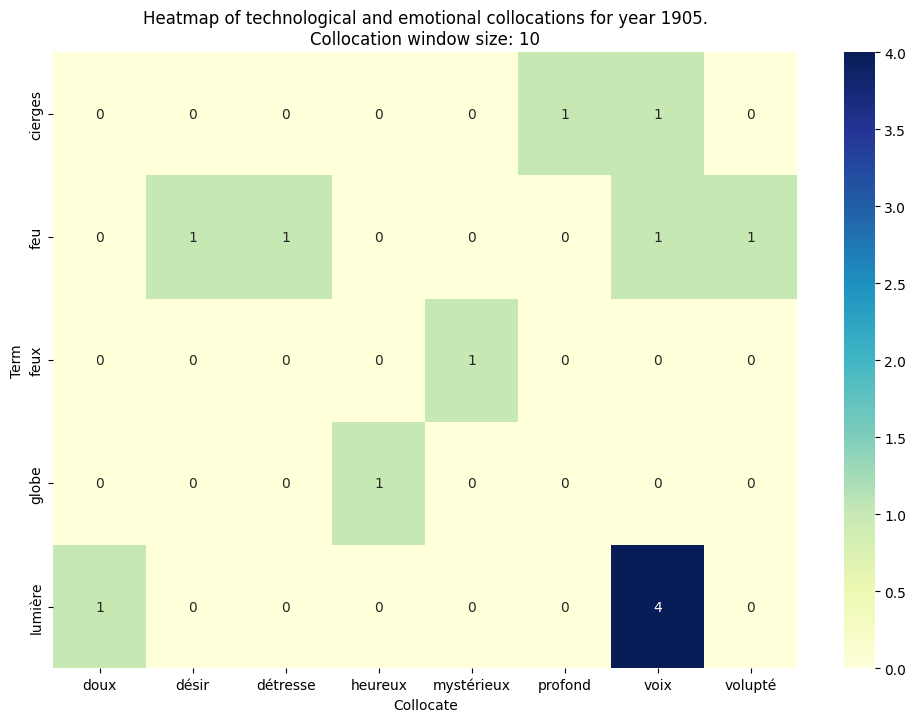

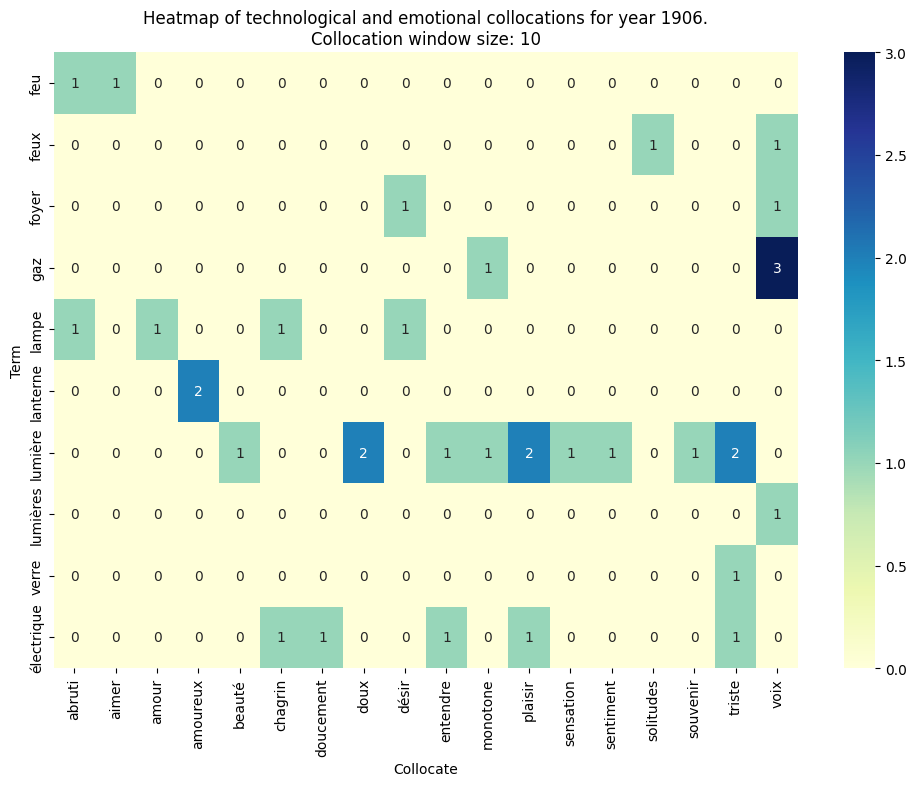

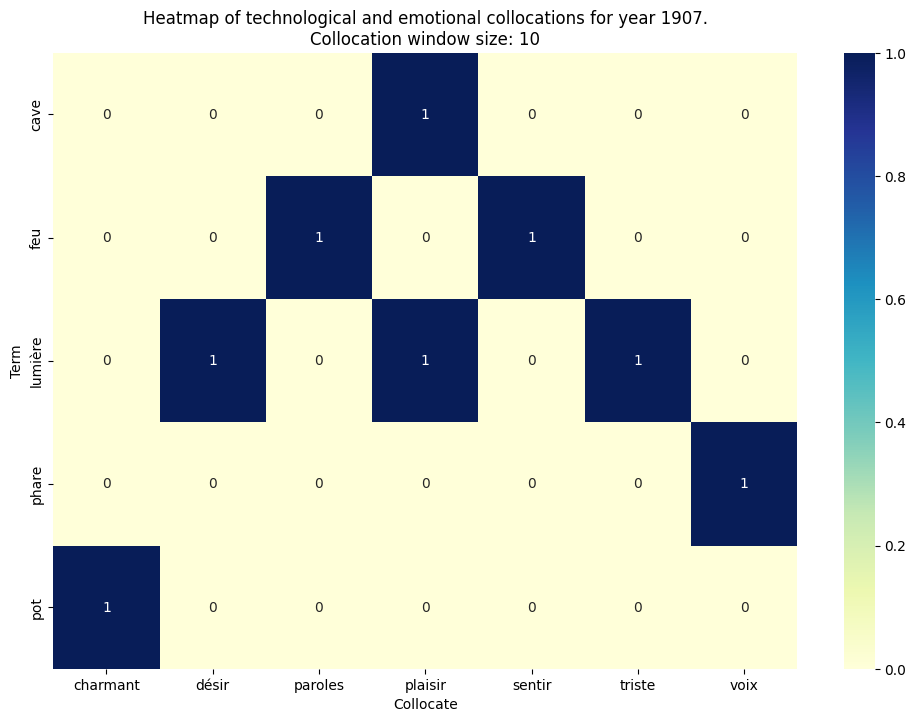

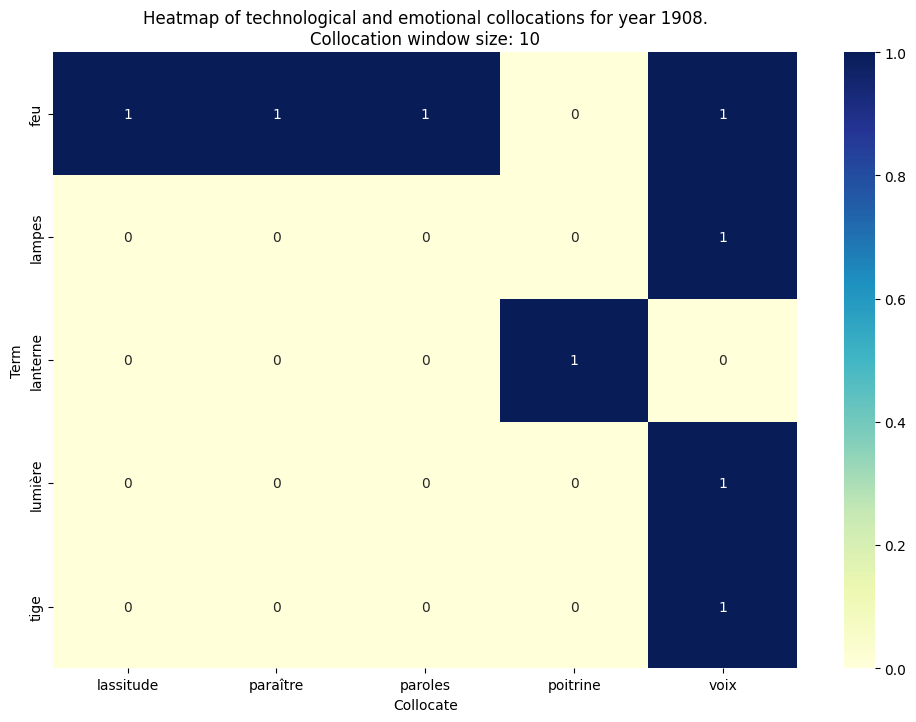

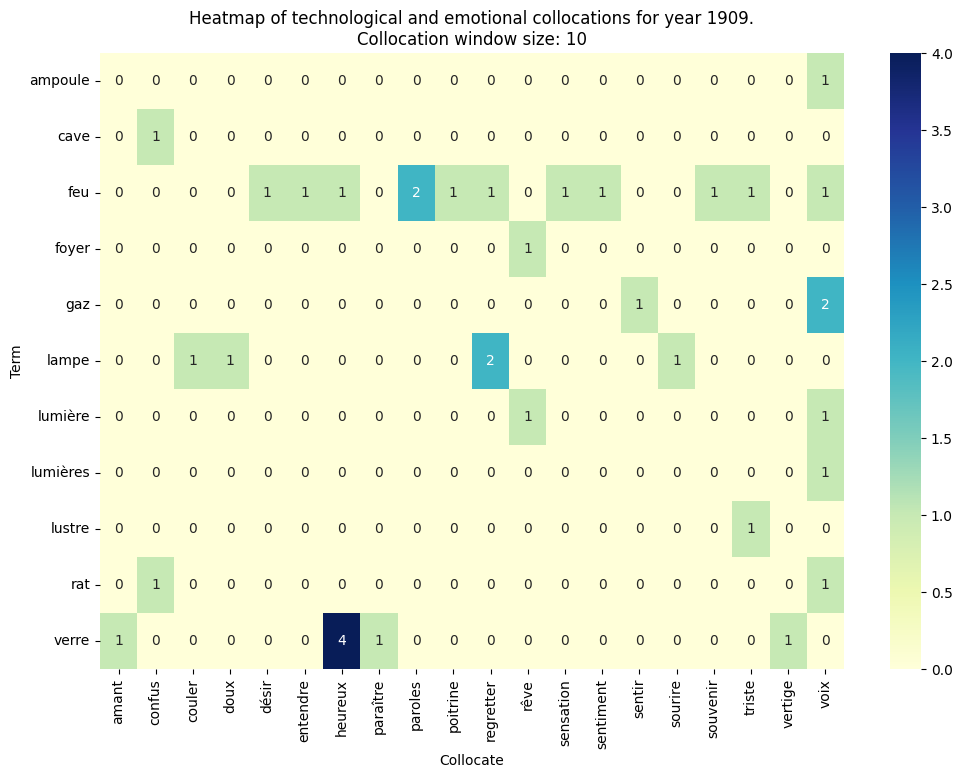

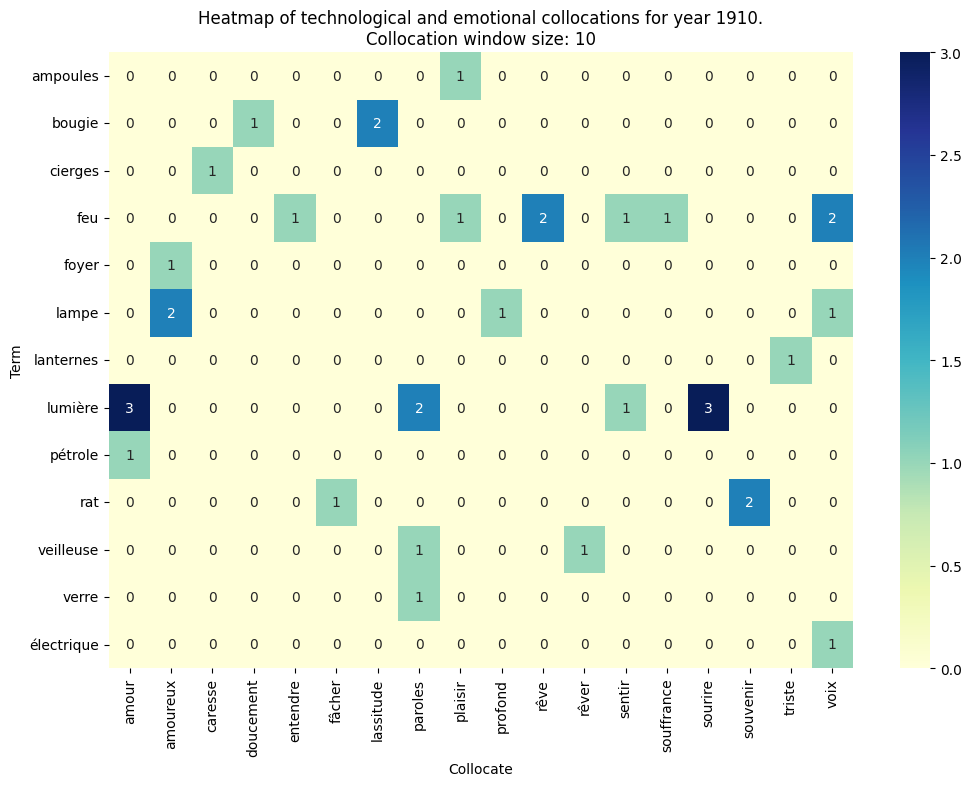

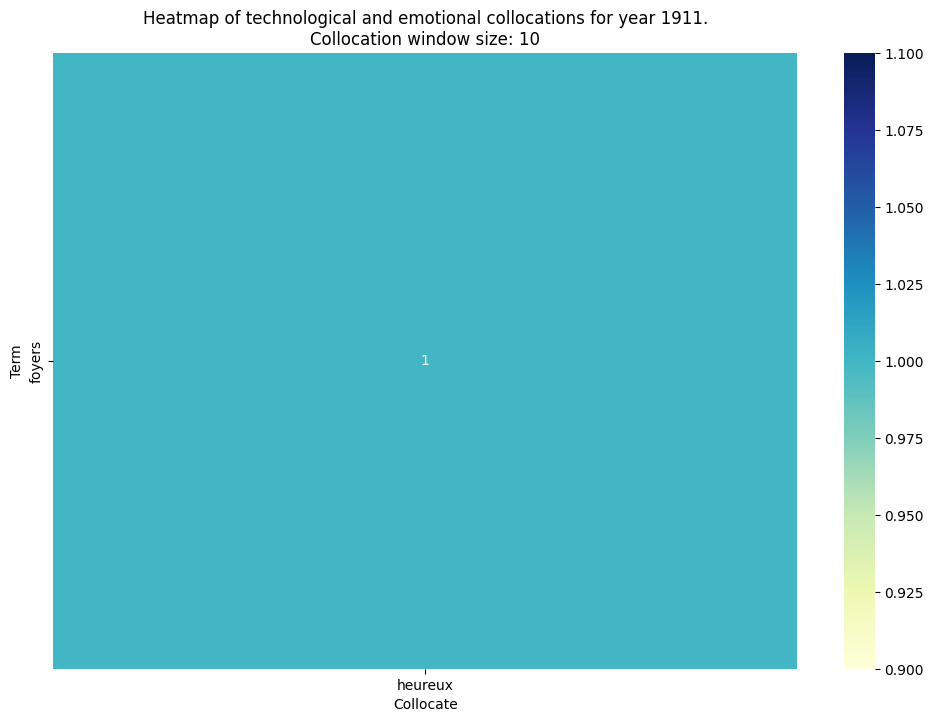

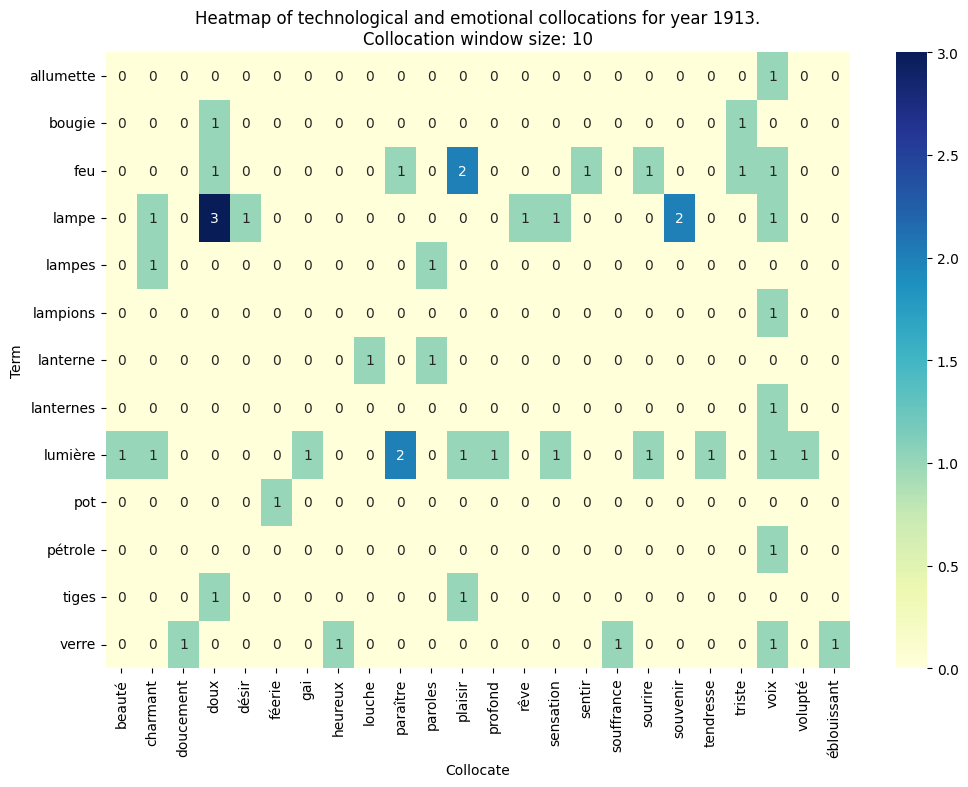

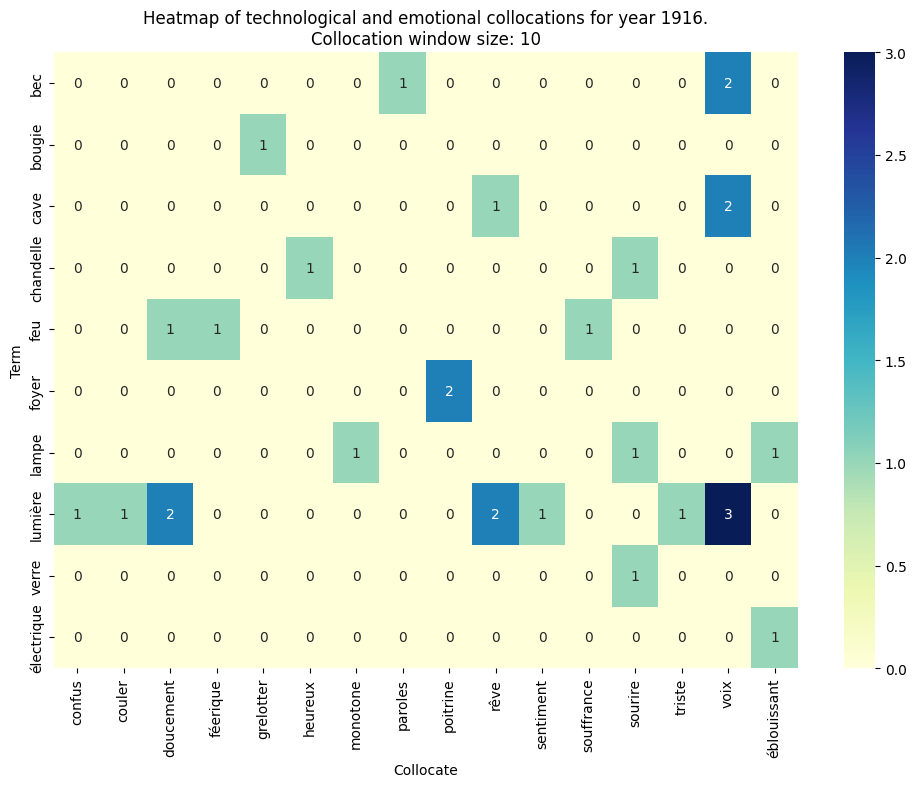

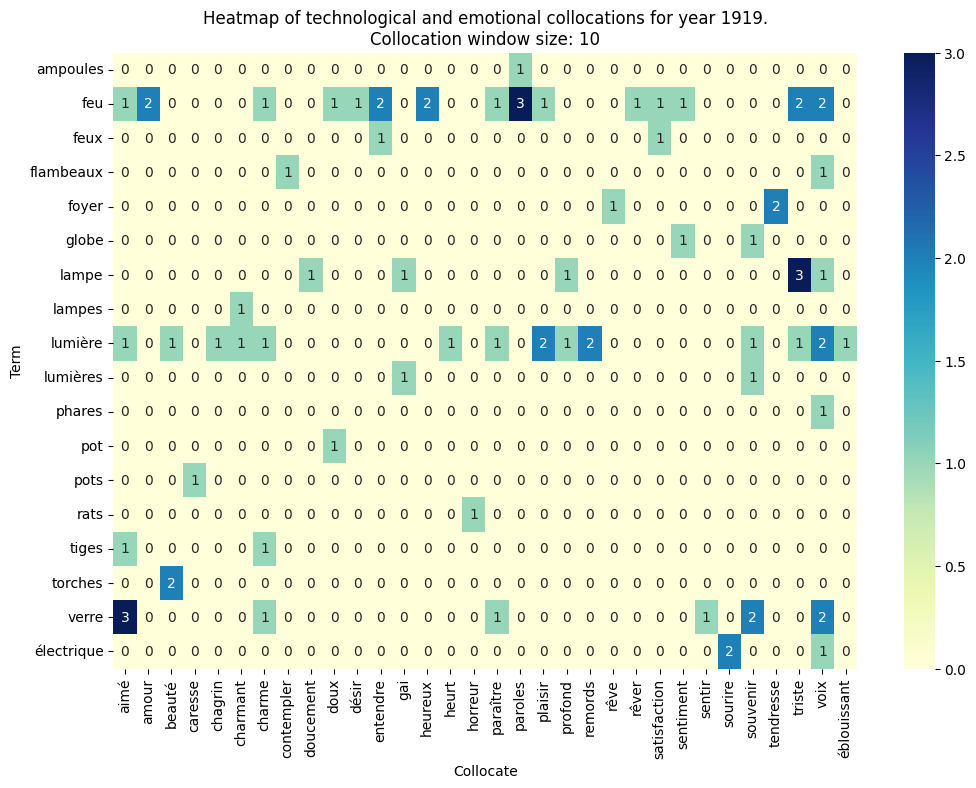

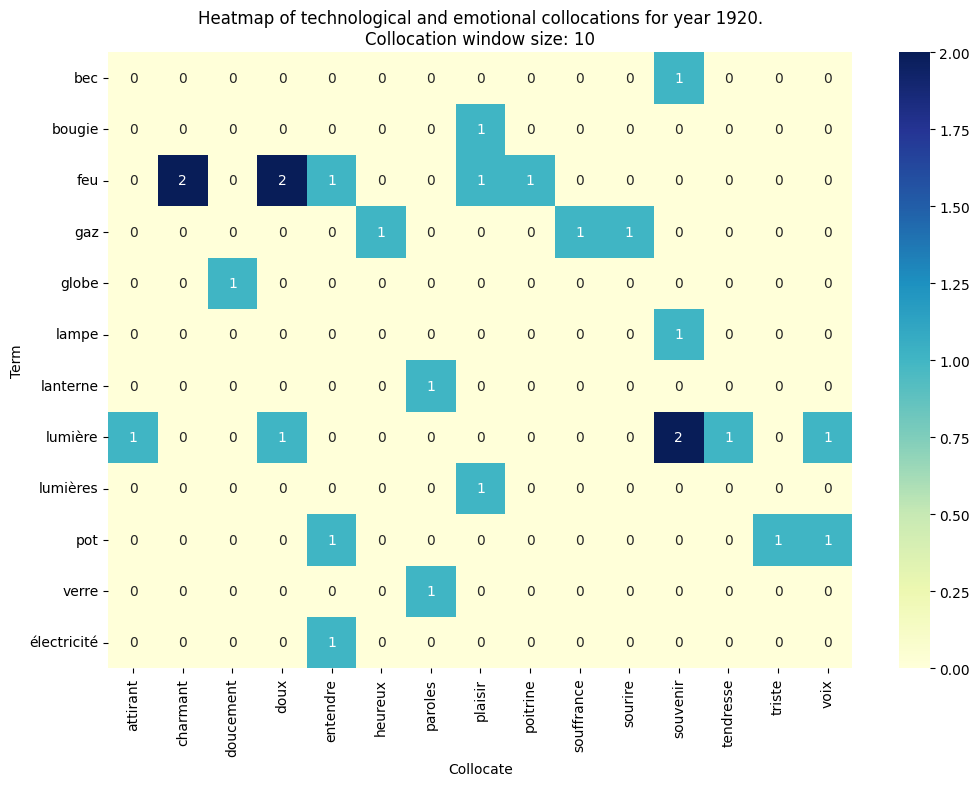

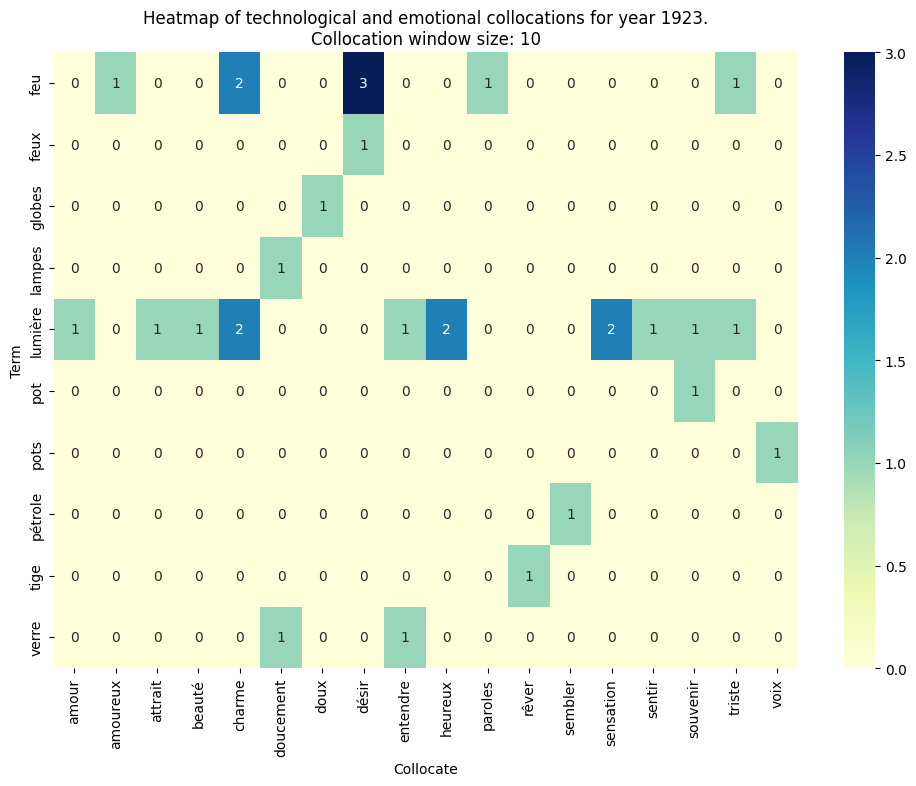

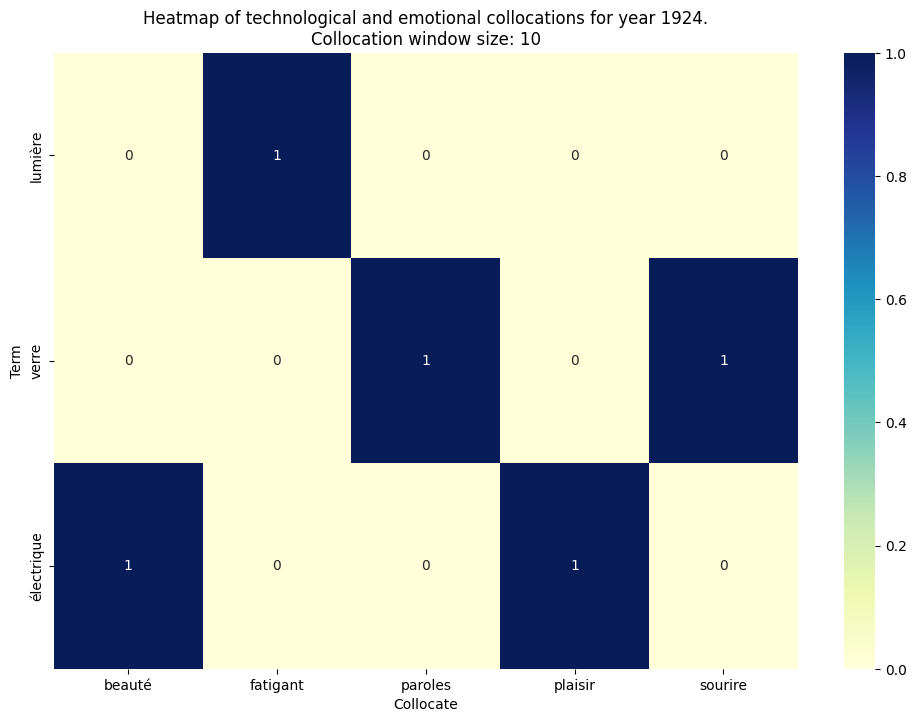

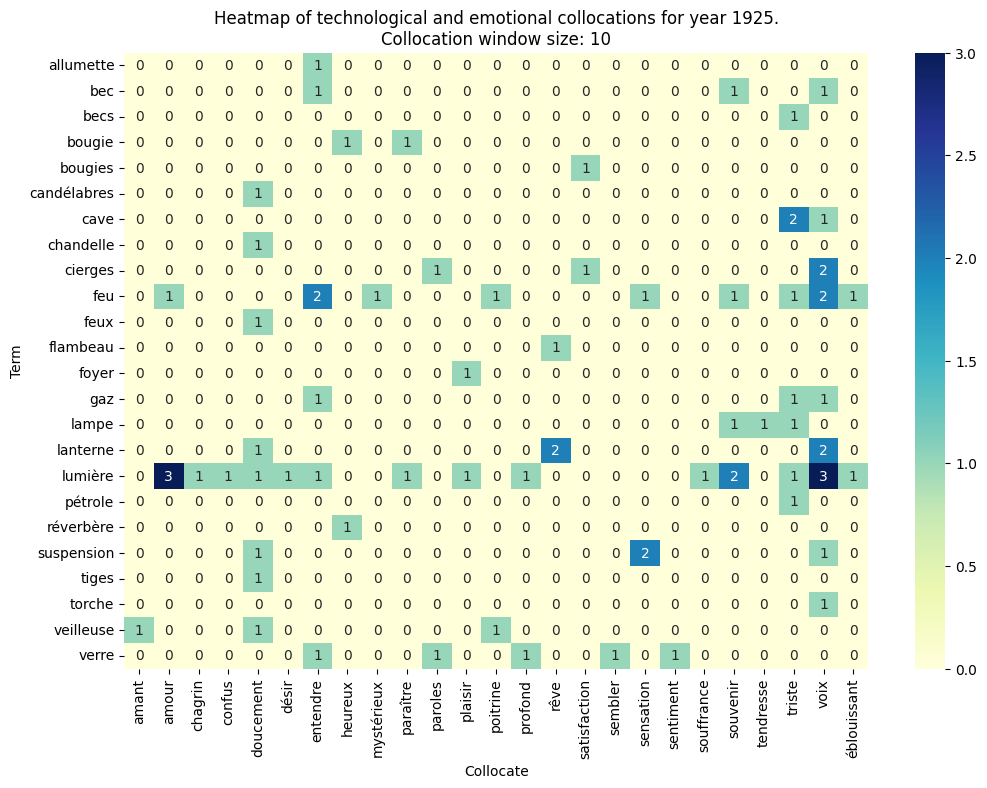

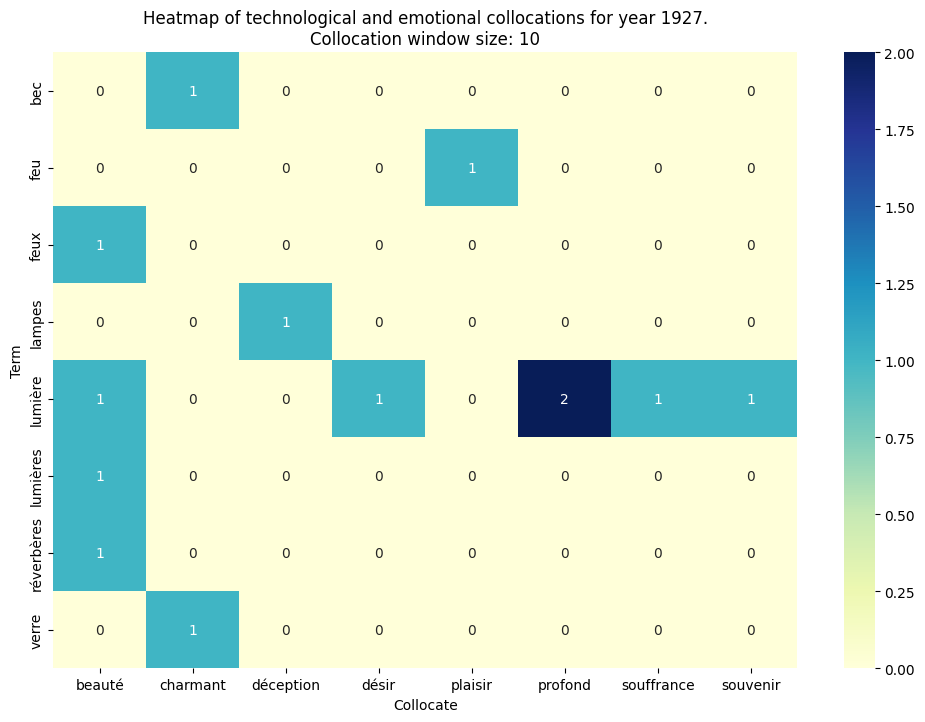

In [14]:
# Define the output directory
output_dir = Path.cwd() / '../visualisations/collocation_heatmaps'

output_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

# Iterate through each row in the DataFrame
for index, row in clean_text_groupby_year[['year', 'collocates']].iterrows():
    year = row['year']
    collocates_data = row['collocates']
    
    # Convert the collocates data to a DataFrame
    df_input = pd.DataFrame(collocates_data)
    
    # Check if 'Count' column exists
    if 'Count' not in df_input.columns:
        print(f"Skipping year {year} due to missing 'Count' column.")
        continue
    
    # Pivot the DataFrame to create a matrix for the heatmap
    heatmap_data = df_input.pivot_table(index='Term', columns='Collocate', values='Count', fill_value=0)
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
    plt.title(f'Heatmap of technological and emotional collocations for year {year}.\nCollocation window size: 10')
    
    # Save the heatmap as a JPG file
    output_file = output_dir / f'heatmap_{year}.jpg'
    plt.savefig(output_file, format='jpg')
    
    # Show the plot (optional, can be removed if not needed)
    plt.show()
    
    # Close the plot to free up memory
    plt.close()

## Visualise the sum of collocated key words vs years 

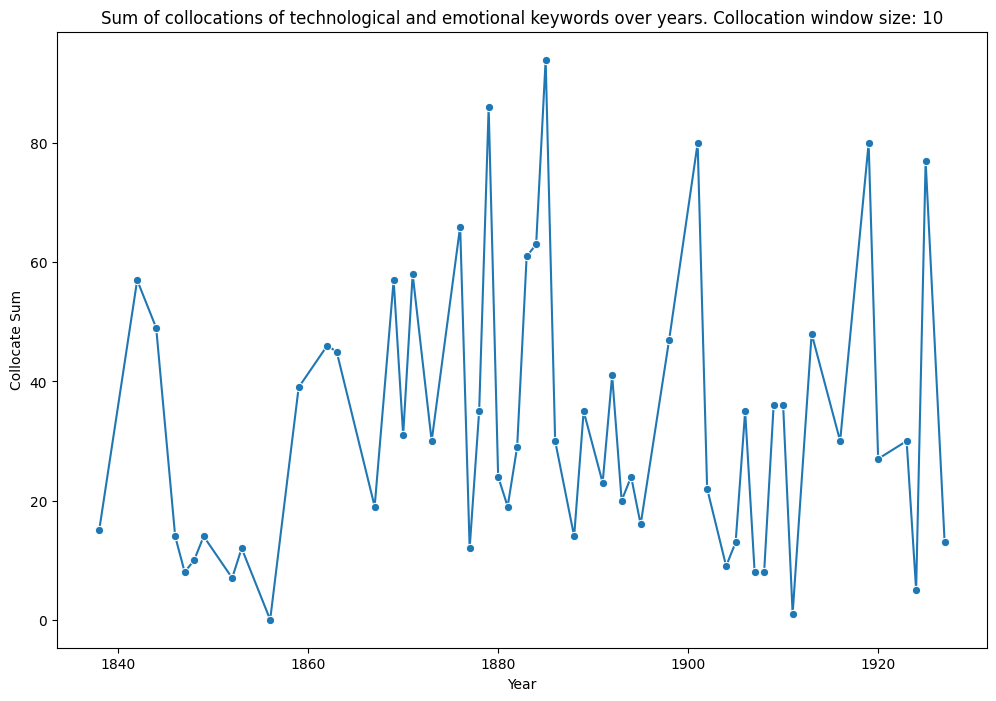

In [16]:
# Iterate through each row in the DataFrame
# Define the output directory
output_dir = Path.cwd() / '../visualisations'
output_dir.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists

collocate_sum = []
for index, row in clean_text_groupby_year[['year', 'collocates']].iterrows():
    year = row['year']
    collocates_data = row['collocates']
    
    # Convert the collocates data to a DataFrame
    df_input = pd.DataFrame(collocates_data)
    
    # Check if 'Count' column exists
    if 'Count' not in df_input.columns:
        collocate_sum.append(0)
        continue
    
    col_sum = df_input['Count'].sum()
    collocate_sum.append(col_sum)

year_collocate_sum_df = pd.DataFrame({'year': clean_text_groupby_year['year'],
                                      'collocate_sum': collocate_sum})

plt.figure(figsize=(12, 8))
# Plot the data using seaborn lineplot
sns.lineplot(x='year', y='collocate_sum', marker='o', data=year_collocate_sum_df)

# Add title and labels
plt.title('Sum of collocations of technological and emotional keywords over years. Collocation window size: 10')
plt.xlabel('Year')
plt.ylabel('Collocate Sum')

# Save the plot as a JPG file
output_file = output_dir / 'collocate_sum_plot.jpg'
plt.savefig(output_file, format='jpg')

# Show the plot
plt.show()